# Imports

In [1]:
!pip install contractions

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import zstandard as zstd
from zstandard import ZstdDecompressor

import json
import pickle

import re
import string
import datetime
import unicodedata
import contractions

# 
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
nltk.download('punkt')
nltk.download('stopwords')
import contractions

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.feature_extraction import text
import seaborn as sns

[nltk_data] Downloading package punkt to
[nltk_data]     /home/msds2022/smendoza/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/msds2022/smendoza/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Functions

## Data Extraction: Reddit *.zst to pickle

The function below accepts a parameter to specify that subreddit that will be extracted and a list of compressed files that contains the reddit data. The function will decompress these files by chunk to avoid Dead Kernels.

In [2]:
def extract_reddit(fname, subreddit):
    """Return list of Json objects from Reddit filename

    Thanks to Prof Leo for code snippetse on the extraction 
    of chunk of bytes at a time. This function can extract 
    from compression .zst only.

    Input
    -----
    fname: filename
        String
    subreddit: subreddit label
        String

    Result
    ------
    list of json objects from reddit submissions for specified filename
        having the subreddit key equal to input subreddit
    """

    # Static filepath for source of Reddit Data
    path = '/mnt/data/public/reddit/submissions/'
    fp = path + fname
    print('* Processing:', fp)

    json_extracted = []
    with open(fp, "rb") as fh:
        dctx = zstd.ZstdDecompressor()
        print('>>Starting', end='')
        with dctx.stream_reader(fh) as reader:
            previous_line = ""
            while True:
                chunk = reader.read(2**24)
                if not chunk:
                    break
                string_data = chunk.decode('utf-8')
                lines = string_data.split("\n")
                for i, line in enumerate(lines[:-1]):
                    if i == 0:
                        line = previous_line+line
                    text = json.loads(line)
                    text_sub = str.lower(text['subreddit'])
                    # Only extract posts that are for specified subreddit
                    if text_sub == subreddit:
                        json_extracted.append(text)
                previous_line = lines[-1]

    print('Completed')
    return json_extracted



def reddit_to_file(subname, fp_list, fp_dir, fp_name):
    """Create pickle files of specific redidit subreddits
    
    Input:
    subname: subreddit name
    fp_list: list of files from subreddit directory
    fp_dir: target directory of pickle files
    fp_name: filename for generated pickle file
    """
    
    for fname in fp_list:

        # create new dictionary per file
        json_all = dict()

        # subreddit of interest is 'philippines'
        x = extract_reddit(fname, subname)

        fname_date = fname.split('.')[0]
        json_all[fname_date] = x
        #for each source file, print number of json objects extracted
        print(f"File: {fname_date} >> {len(x)}")

    # Once all files are extracted as json objects
    # Write into a pickle file
        fp = fp_dir + fp_name
        print(fp)
        with open(f"{fp_dir}_{fname_date}.pkl","wb") as file:
            pickle.dump(json_all, file)


### Execution

**Define the following**:

*List of all the Reddit files to be extracted
*Target filepath
*

For each of the reddit files, create separate pickle files that contain dictionary object having
* key = filename without extension
* item = list of json objects meeting having specified subreddit topic

Write pickle files in subfolder ```/data_preprocessed``` with filename ```RS_YYYY-MM.pkl```

In [3]:
fp_list = [
    'RS_2020-01.zst', 'RS_2020-02.zst', 'RS_2020-03.zst', 'RS_2020-04.zst'
]

sub_reddit = 'writingprompts'
fp_dir = "./data_preprocessed/"
fp_name = "wp"

# Files wil be created in: <fp_dir><fp_name>_<fp_list name>.pkl


In [4]:
# Modify to True if you want to run the extraction again
# BE CAREFUL!
overwrite = False

# Extraction proper
if overwrite == True:

    reddit_to_file(
        'writingprompts',
        fp_list,
        "./data_preprocessed/"
        "wp"
    )

**Log of extraction with accompanying count of json objects saved**

* Processing: /mnt/data/public/reddit/submissions/RS_2020-01.zst
>StartingCompleted
File: RS_2020-01 >> 9196
* Processing: /mnt/data/public/reddit/submissions/RS_2020-02.zst
>StartingCompleted
File: RS_2020-02 >> 8792
* Processing: /mnt/data/public/reddit/submissions/RS_2020-03.zst
>StartingCompleted
File: RS_2020-03 >> 9242
* Processing: /mnt/data/public/reddit/submissions/RS_2020-04.zst
>StartingCompleted
File: RS_2020-04 >> 9147


## Data Extraction: pickle to json to list of titles

Each reddit post is represented as a json object. <br>
The following information (as keys) are of interest
* subreddit - filtered on Philippines
* title
* subreddit_subscribers: 307386
* 'created_utc': ie, 1585699535
* num_comments: number of comments
* score
* over_18

In [5]:
def reddit_titles(in_files, subreddit, fp_dir, fp_name, lower=False):
    """Return list of all reddit titles from given files

    Input:
    files: list of reddit filenames
        Extension not relevant
        Corresponding Pickle files will be retrieved in subfolder:
        ./data_preprocessed/reddit_<filename>.pkl
    lower: boolean
        default is False
        if True, will change titles to lowercase
    subname: subreddit name
    fp_dir: target directory of pickle files
    fp_name: filename for generated pickle file

    Return:
    out_titles: list of titles
    out_dates: list of date YYYY-MM each title comes from
        there is 1:1 correspondence between 2 tables
    out_create: post creation date in UTC
    out_comments: number of comments
    out_ups: ups
    out_awards: total awards received
    """
    out_titles = []
    out_dates = []
    out_create = []
    out_comments = []
    out_score = []
    out_18 = []
    out_subs = []

    for fname in in_files:

        fname_date = fname.split('.')[0]
#         fp = f"./data_preprocessed/reddit_{fname_date}.pkl"
        fp = fp_dir + fp_name + f'_{fname_date}.pkl'
        print(fname_date, fp)

        reddit_json = pd.read_pickle(fp)
        for each in reddit_json[fname_date]:
            out_dates.append(fname_date.split('_')[1])
            out_subs.append(each['subreddit_subscribers'])
#             out_subs.append(each[subreddit])

            create_date = datetime.datetime.fromtimestamp(each['created_utc'])
            out_create.append(create_date)
            out_comments.append(each['num_comments'])
            out_score.append(each['score'])
            out_18.append(each['over_18'])
            
            if lower:
                out_titles.append(str.lower(each['title']))
            else:
                out_titles.append(each['title'])
    
    return (out_titles, out_dates, out_subs, out_create,
            out_comments, out_score, out_18)

## Data Prep: Json to DataFrame

In [6]:
def reddit_to_df(fp_list):
    """Build working dataframe from extracted subreddit json objects

    Input: 
    fp_list: list of original reddit file sources
    
    Result:
    df: complete"""
    print("EXTRACTING:")
    (all_titles, all_dates, all_subscribers, all_creation, all_comments,
     all_score, all_18) = reddit_titles(fp_list, sub_reddit, fp_dir, fp_name, lower=True)

    df = pd.DataFrame({
        'month': all_dates,
        'titles': all_titles,
        'subscribers': all_subscribers,
        'create_date': all_creation,
        'comments': all_comments,
        'score': all_score,
        '18up': all_18
    })

    print("\nTotal number of titles extracted: ", len(all_titles))
    
    return df

### Execution

In [7]:
extract_fp = ['RS_2020-01.zst', 'RS_2020-02.zst', 
              'RS_2020-03.zst', 'RS_2020-04.zst']

df = reddit_to_df(extract_fp)
df

EXTRACTING:
RS_2020-01 ./data_preprocessed/wp_RS_2020-01.pkl
RS_2020-02 ./data_preprocessed/wp_RS_2020-02.pkl
RS_2020-03 ./data_preprocessed/wp_RS_2020-03.pkl
RS_2020-04 ./data_preprocessed/wp_RS_2020-04.pkl

Total number of titles extracted:  36377


month                                             titles  \
0      2020-01  [wp] you enter the barred gates into a lusciou...   
1      2020-01  [wp] 10, 9, 8, 7, 6, 5, 4, 3, 2, 1...happy new...   
2      2020-01  [wp] you just won the big jackpot. 3 billion d...   
3      2020-01  [sp] a retired supervillain becomes a city's u...   
4      2020-01  [wp] the galaxy is in shambles after one stupi...   
...        ...                                                ...   
36372  2020-04  [wp] there was a mistranslation in the bible. ...   
36373  2020-04  [wp] all humans have suddenly transformed to e...   
36374  2020-04  [eu] take your favorite fictional universe, an...   
36375  2020-04  [wp] - you were just arrested and locked in ja...   
36376  2020-04  [sp] write a dialogue that makes us believe pr...   

       subscribers         create_date  comments  score   18up  
0         14367885 2020-01-01 00:00:58         1     15  False  
1         14367885 2020-01-01 00:01:38         2      7  False  
2         14367885 2020-01-01 00:02:13         3     73  False  
3         14367886 2020-01-01 00:06:51         1     13  False  
4         14367886 2020-01-01 00:07:36         1      7  False  
...            ...                 ...       ...    ...    ...  
36372     14410193 2020-04-30 23:26:15         1      1  False  
36373     14410237 2020-04-30 23:46:04         1      1  False  
36374     14410247 2020-04-30 23:51:38         1      1  False  
36375     14410249 2020-04-30 23:55:17         1      2  False  
36376     14410258 2020-04-30 23:59:57         1      1  False  

[36377 rows x 7 columns]

## Data Preprocessing: Cleaning up the titles

In [8]:
#Cleanup titles and save df local file
def remove_numbers(text):
    """Remove numbers from text"""
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    return re.sub(pattern, '', text)

def remove_punctuation(text):
    """Remove punctuation from text"""
#     pattern = r'[.,!?/:;\"\'\s]' 
    pattern = r'[.,!?/:;\"\s]' 
    return re.sub(pattern, ' ', text)

def remove_tag(text):
    """Remove title tags"""
    pattern = r'\[\w\w\](.*)'
    temp = re.match(pattern, ' ', text)
    if len(temp) == 0:
        return text
    else:
        return temp
    
#Lemmatization
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]

def my_preprocess(df_in):
    """Perform preprocessing steps on Reddit Titles DataFrame
    
    Input:
    ------
    df_in: DataFrame having column 'titles' to be cleaned
    
    Result:
    ------
    df: the original DataFrame with additional columns
        tokenized: list of words of title
        clean_title: String of title that has been cleaned 
            (for use in TFIDF)
        chars: number of characters in the title
        words: number of words
    """
    
    df = df_in.copy()
    
    df["titles"] = df["titles"].apply(contractions.fix)

    df["titles"] = df["titles"].replace(r'\n', ' ', regex=True) 
    df["titles"] = df["titles"].replace(r'\t', ' ', regex=True) 
    df["titles"] = df["titles"].replace(r' \d+', ' ', regex=True)
    df["titles"] = df["titles"].replace(r"'", '', regex=True)
    df["titles"] = df["titles"].replace(r"’", '', regex=True)
    df["titles"] = df["titles"].replace(r'/t', ' ', regex=True)

    df['titles'] = df['titles'].apply(remove_numbers)
    df['titles'] = df['titles'].apply(remove_punctuation)
    df['tag'] = df['titles'].str.extract(r'(\[\w\w\]).+')

    df[['tag', 'clean_title1', 'clean_title2']] = df['titles'].str.extract(r'^(\[\w\w\])(.*)|^(.*)', expand=True)
    df.fillna('', inplace=True)
    df['clean_title'] = df['clean_title1'].astype(str) + df['clean_title2'].astype(str)
    df.drop(['clean_title1', 'clean_title2'], axis=1, inplace=True)

    # Temporary Tokenization, #Lemmatization
    df['tokenized'] = df['clean_title'].apply(word_tokenize)
    df['tokenized'] = df['tokenized'].apply(lemmatize_text)
    df['clean_title'] = df['tokenized'].str.join(" ")

    df['chars'] = df['clean_title'].str.len()
    df['words'] = df['tokenized'].apply(len)
    
    return df

In [9]:
# Execute the preprocessor
df = my_preprocess(df)

df.head()

month                                             titles  subscribers  \
0  2020-01  [wp] you enter the barred gates into a lusciou...     14367885   
1  2020-01  [wp]                      happy new ye   wait ...     14367885   
2  2020-01  [wp] you just won the big jackpot   billion do...     14367885   
3  2020-01  [sp] a retired supervillain becomes a citys un...     14367886   
4  2020-01  [wp] the galaxy is in shambles after one stupi...     14367886   

          create_date  comments  score   18up   tag  \
0 2020-01-01 00:00:58         1     15  False  [wp]   
1 2020-01-01 00:01:38         2      7  False  [wp]   
2 2020-01-01 00:02:13         3     73  False  [wp]   
3 2020-01-01 00:06:51         1     13  False  [sp]   
4 2020-01-01 00:07:36         1      7  False  [wp]   

                                         clean_title  \
0  you enter the barred gate into a luscious extr...   
1  happy new ye wait what everyone suddenly disap...   
2  you just won the big jackpot billion dollar yo...   
3  a retired supervillain becomes a city unlikely...   
4  the galaxy is in shamble after one stupid race...   

                                           tokenized  chars  words  
0  [you, enter, the, barred, gate, into, a, lusci...    268     49  
1  [happy, new, ye, wait, what, everyone, suddenl...     52      8  
2  [you, just, won, the, big, jackpot, billion, d...    164     29  
3  [a, retired, supervillain, becomes, a, city, u...     56      9  
4  [the, galaxy, is, in, shamble, after, one, stu...    123     20

### Saving DF to file or retrieving from file

Change ```overwrite = True``` if you want to overwrite file

In [10]:
# WARNING: Change value to True if you want file to be created/overwritten
overwrite = False

# Extraction proper
if overwrite == True:

    # create new dictionary key per object
#     data_ex = [x_words, x_text, all_dates, all_subscribers, all_18]

    #for each source file, print number of json objects extracted
    print(f"File: saving")

    # Write into a pickle file
    # Uncomment if rewriting files.
    with open(f"./data_postprocessed/df_all.pkl","wb") as file:
        pickle.dump(df, file)

    print('done!')


**Optional:** Retrieve previously saved DF

In [11]:
# df = pd.read_pickle(f"./data_postprocessed/df_all.pkl")
# df

# Initial EDA on data: df

What I want to find out
* Posts: in total, per month
* word count: average, histogram, trend
* comments: min, max, histogram
* score: upvotes - downvotes


* Tags:

        WP: Writing Prompt
        SP: Simple Prompt
        EU: Established Universe
        CW: Constrained Writing
        TT: Theme Thursday
        PM: Prompt Me
        MP: Media Prompt
        IP: Image Prompt
        PI: Prompt Inspired
        OT: Off Topic
        * OT as an Advertisement!
        RF: Reality Fiction



Number of titles in total, per month

In [12]:
print(f"Total number of Reddit posts are :{df.shape[0]}")
print("Total number of posts per month:")
df.groupby('month')['clean_title'].count()

Total number of Reddit posts are :36377
Total number of posts per month:


month
2020-01    9196
2020-02    8792
2020-03    9242
2020-04    9147
Name: clean_title, dtype: int64

In [13]:
print(f"Total number of Reddit posts are :{df.shape[0]}")
print("Total number of posts per month:")
df.groupby('month')['tag'].value_counts()

Total number of Reddit posts are :36377
Total number of posts per month:


month    tag 
2020-01  [wp]    6953
                 1206
         [eu]     468
         [sp]     240
         [ip]     101
                 ... 
2020-04  [tb]       1
         [ue]       1
         [wf]       1
         [ws]       1
         [wt]       1
Name: tag, Length: 95, dtype: int64

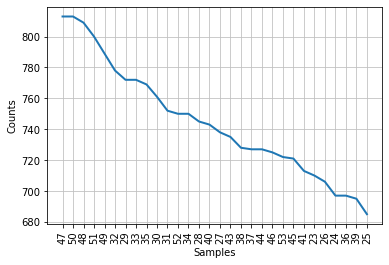

In [14]:
# plot of word frequency
fdist = FreqDist(df['words'])
fdist.plot(30,cumulative=False)
plt.show()

<AxesSubplot:xlabel='words', ylabel='Count'>

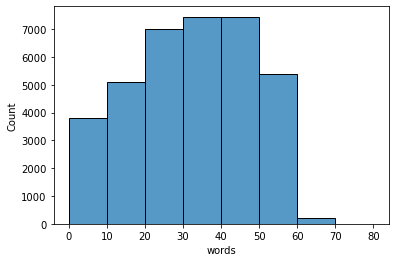

In [15]:
# histogram of number of words per title
sns.histplot(data=df, x="words", binwidth=10)

2020-01


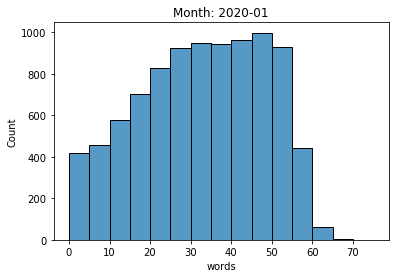

2020-02


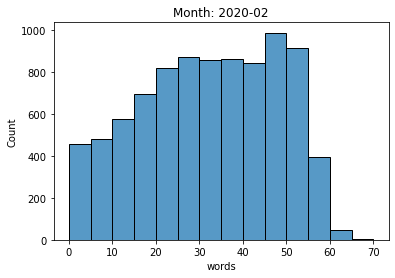

2020-03


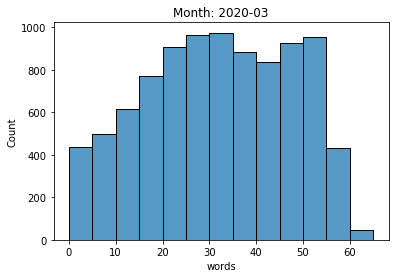

2020-04


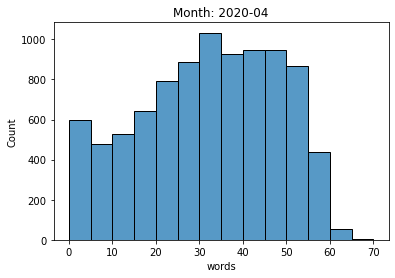

In [16]:
# histogram of words per month:

for i in df['month'].unique():
    print(i)
    
    # histogram of number of words per title
    sns.histplot(data=df[df['month']==i], x="words", binwidth=5)
    plt.title(f"Month: {i}")
    plt.show()

# Defining Scope: slicing/setting

We focus on only titles which have high scores for each month. We filter the scope down to the top 10% of scores.

In [17]:
df1 = df[df['month'] == '2020-01']
df1 = df1.sort_values('score',ascending=False).head(int(df1.shape[0]*.1))
print("January: ", df1.shape)
df1.head()

January:  (919, 12)


month                                             titles  subscribers  \
862   2020-01  [wp] cats live for fifteen to twenty years  mi...     14368590   
4027  2020-01  [wp] you are a witch who offers couples deals ...     14371344   
7726  2020-01  [wp] there is a parallel universe where people...     14374535   
3429  2020-01  [wp]you have had bad luck your whole life  one...     14370913   
4676  2020-01  [wp]   million slaves as tribute  the alien ar...     14372068   

             create_date  comments  score   18up   tag  \
862  2020-01-03 21:32:01       166  17068  False  [wp]   
4027 2020-01-14 18:39:54       309  15931  False  [wp]   
7726 2020-01-27 11:33:18       264  14780  False  [wp]   
3429 2020-01-12 19:04:36       170  14305  False  [wp]   
4676 2020-01-17 01:16:26       259  14278  False  [wp]   

                                            clean_title  \
862   cat live for fifteen to twenty year mouse for ...   
4027  you are a witch who offer couple deal in retur...   
7726  there is a parallel universe where people age ...   
3429  you have had bad luck your whole life one day ...   
4676  million slave a tribute the alien armada deman...   

                                              tokenized  chars  words  
862   [cat, live, for, fifteen, to, twenty, year, mo...    208     39  
4027  [you, are, a, witch, who, offer, couple, deal,...    202     39  
7726  [there, is, a, parallel, universe, where, peop...    200     41  
3429  [you, have, had, bad, luck, your, whole, life,...    279     60  
4676  [million, slave, a, tribute, the, alien, armad...    255     46

In [18]:
df2 = df[df['month'] == '2020-02']
df2 = df2.sort_values('score',ascending=False).head(int(df2.shape[0]*.1))
print("February: ", df2.shape)
df2.head()

February:  (879, 12)


month                                             titles  \
17235  2020-02  [wp] you are a child therapist who treats extr...   
16017  2020-02  [wp] the healer was treated horribly by the kn...   
16648  2020-02  [wp] you are a nice person  but your superpowe...   
11721  2020-02  [wp] human blood turns darker with every evil ...   
17630  2020-02  [wp] as a teen  you daydreamed and wrote about...   

       subscribers         create_date  comments  score   18up   tag  \
17235     14387236 2020-02-27 15:28:05       272  16298  False  [wp]   
16017     14385934 2020-02-23 18:00:56       361  13987  False  [wp]   
16648     14386434 2020-02-25 17:38:54       364  13661  False  [wp]   
11721     14381691 2020-02-09 16:38:31       332  12943  False  [wp]   
17630     14387739 2020-02-28 20:04:27       173  11605  False  [wp]   

                                             clean_title  \
17235  you are a child therapist who treat extreme ca...   
16017  the healer wa treated horribly by the knight h...   
16648  you are a nice person but your superpower is t...   
11721  human blood turn darker with every evil deed a...   
17630  a a teen you daydreamed and wrote about a fict...   

                                               tokenized  chars  words  
17235  [you, are, a, child, therapist, who, treat, ex...    259     46  
16017  [the, healer, wa, treated, horribly, by, the, ...    273     52  
16648  [you, are, a, nice, person, but, your, superpo...    253     43  
11721  [human, blood, turn, darker, with, every, evil...    240     45  
17630  [a, a, teen, you, daydreamed, and, wrote, abou...    254     48

In [19]:
df3 = df[df['month'] == '2020-03']
df3 = df3.sort_values('score',ascending=False).head(int(df3.shape[0]*.1))
print("March: ", df3.shape)
df3.head()

March:  (924, 12)


month                                             titles  \
23435  2020-03  [wp] at the age of  everyone gets teleported i...   
23222  2020-03  [wp] the antichrist came and went  but no one ...   
25263  2020-03  [wp] in a dystopian theocracy  criminals get i...   
20490  2020-03  [wp] as an immortal and hopeless romantic  you...   
26459  2020-03  [wp] you study magic at the top school in the ...   

       subscribers         create_date  comments  score   18up   tag  \
23435     14392690 2020-03-19 14:02:45       783  17080  False  [wp]   
23222     14392484 2020-03-18 19:27:50       242  15837  False  [wp]   
25263     14394440 2020-03-25 12:27:31       219  13353  False  [wp]   
20490     14389755 2020-03-09 16:39:34       135  12728  False  [wp]   
26459     14395906 2020-03-29 14:33:17       204  12524  False  [wp]   

                                             clean_title  \
23435  at the age of everyone get teleported into a s...   
23222  the antichrist came and went but no one notice...   
25263  in a dystopian theocracy criminal get injected...   
20490  a an immortal and hopeless romantic you fake y...   
26459  you study magic at the top school in the world...   

                                               tokenized  chars  words  
23435  [at, the, age, of, everyone, get, teleported, ...    263     54  
23222  [the, antichrist, came, and, went, but, no, on...    270     55  
25263  [in, a, dystopian, theocracy, criminal, get, i...    280     49  
20490  [a, an, immortal, and, hopeless, romantic, you...    198     34  
26459  [you, study, magic, at, the, top, school, in, ...    282     51

In [20]:
df4 = df[df['month'] == '2020-04']
df4 = df4.sort_values('score',ascending=False).head(int(df4.shape[0]*.1))
print("April: ", df4.shape)
df4.head()

April:  (914, 12)


month                                             titles  \
30691  2020-04  [wp] you have been kidnapped by a cult prepari...   
33471  2020-04  [wp] a yearold schoolgirl is taken to a magica...   
28010  2020-04  [wp] you are a dragon  after moving to your ne...   
29368  2020-04  [wp] you grew up in a religious family  due to...   
32286  2020-04  [wp]time travel is possible  but requires an  ...   

       subscribers         create_date  comments  score   18up   tag  \
30691     14400080 2020-04-12 01:36:11       172  17681  False  [wp]   
33471     14402966 2020-04-21 13:01:16       338  14955  False  [wp]   
28010     14397304 2020-04-03 11:28:27       820  14189  False  [wp]   
29368     14398670 2020-04-07 10:47:53       210  13882  False  [wp]   
32286     14401702 2020-04-17 14:38:54       239  12951  False  [wp]   

                                             clean_title  \
30691  you have been kidnapped by a cult preparing to...   
33471  a yearold schoolgirl is taken to a magical wor...   
28010  you are a dragon after moving to your new fore...   
29368  you grew up in a religious family due to a min...   
32286  time travel is possible but requires an anchor...   

                                               tokenized  chars  words  
30691  [you, have, been, kidnapped, by, a, cult, prep...    225     44  
33471  [a, yearold, schoolgirl, is, taken, to, a, mag...    265     51  
28010  [you, are, a, dragon, after, moving, to, your,...    212     41  
29368  [you, grew, up, in, a, religious, family, due,...    260     45  
32286  [time, travel, is, possible, but, requires, an...    279     54

In [21]:
corpus1 = df1['clean_title']
corpus2 = df2['clean_title']
corpus3 = df3['clean_title']
corpus4 = df4['clean_title']
# new_corpus = df[(df['tag']=='[wp]') & (df['month']=='2020-01')]['clean_title'] #27159
# print(f'total number of reddit posts for all months: {new_corpus.shape[0]}')

In [22]:
corpus_all = df['clean_title']
corpus_arr = [corpus1, corpus2, corpus3, corpus4]

### Saving DF to file or retrieving from file

Change ```overwrite = True``` if you want to overwrite file

In [23]:
# WARNING: Change value to True if you want file to be created/overwritten
overwrite = False

# Extraction proper
if overwrite == True:

    # create new dictionary key per object
#     data_ex = [x_words, x_text, all_dates, all_subscribers, all_18]

    #for each source file, print number of json objects extracted
    print(f"File: saving")

    # Write into a pickle file
    # Uncomment if rewriting files.
    with open(f"./data_postprocessed/corpus_arr.pkl","wb") as file:
        pickle.dump(corpus_arr, file)

    print('done!')


**Optional:** Retrieve previously saved DF

In [24]:
# corpus_arr = pd.read_pickle(f"./data_postprocessed/corpus_arr.pkl")
# corpus_arr

# Dimensionality Reduction

## TFIDF & SVD - Test run on single month

To perform LSA, we need to vectorize our corpus. We use here TF-IDF:

In [27]:
# Adding new stop words
newStopWords = ['writing', 'prompt', 'write', 'has', 
                'just', 'ha', 'was', 'wa', 'did']
my_stop_words = text.ENGLISH_STOP_WORDS.union(newStopWords)

# TFIDF proper
vectorizer = TfidfVectorizer(
    stop_words = my_stop_words, # use custom list of words + english
    token_pattern=u'(?ui)\\b[a-z]+\\b',
#     max_features= 50_000, # keep top 1000 terms, the higher the better
    max_df = 0.9, # remove words that appear in more than 90%
#     min_df= 15,   # removing words that appear in less than X articles
#     smooth_idf=True,
#     ngram_range=(2,2)
)

X = vectorizer.fit_transform(corpus1)
print("After vectorizing the titles we have:")
print(f'Rows = {X.shape[0]} and Words = {X.shape[1]}')

After vectorizing the titles we have:
Rows = 919 and Words = 4873


Take a peek at the highest words/bigrams

In [28]:
vec_features = vectorizer.get_feature_names()
pd.DataFrame(X.toarray(), columns=vec_features).sum().sort_values(ascending=False)[:50]
# vec_features

world        17.116246
year         15.995650
time         15.700388
human        15.317838
day          14.115507
life         13.636051
people       11.944043
earth        11.443350
hero         10.578533
power         9.940853
new           8.908878
alien         8.810329
come          8.751120
friend        8.741444
like          8.670943
make          8.565107
say           8.546338
know          8.544281
god           8.296190
demon         8.136059
story         7.800744
way           7.561671
thing         7.242576
finally       7.239008
death         7.224027
today         7.083628
want          7.078772
old           7.058479
humanity      7.033177
person        7.029212
start         6.991506
magic         6.985876
look          6.713619
die           6.503157
turn          6.345765
character     6.330105
child         6.177731
planet        6.096209
villain       6.053658
wake          5.982194
best          5.923543
problem       5.758971
doe           5.565999
good       

**Perform SVD**

In [34]:
# SVD represent documents and terms in vectors 
# n_components guidance: ideally #number of words-1
#                        compromise is to start with 500 & trial/error

n_comp = X.shape[1]-1

svd_model = TruncatedSVD(n_components=n_comp)
X_new = svd_model.fit_transform(X)
print("done! X_new shape is now: ", X_new.shape)

feature_names = vectorizer.get_feature_names()
Sigma = svd_model.singular_values_
V_T = svd_model.components_.T
nssd = svd_model.explained_variance_ratio_

done! X_new shape is now:  (919, 919)


In [35]:
X_new.shape

(919, 919)

Save the resulting model & transformed matrix to pickle file.


In [33]:
# BE CAREFUL!
# Modify to True if you want to run the extraction again
from datetime import datetime
overwrite = False

# Saving proper
if overwrite == True:

    # create new dictionary key per object
    json_all = dict()
    json_all['svd_model'] = svd_model
    json_all['lsa_data'] = X_new
    json_all['vectorizer'] = vectorizer
    json_all['df'] = df

    #for each source file, print number of json objects extracted
    print(f"File: saving")

    # Write into a pickle file
    # Uncomment if rewriting files.
    with open(f"./data_postprocessed/bigram_{fname_date}_{datetime.today().strftime('%Y-%m-%d')}.pkl","wb") as file:
        pickle.dump(json_all, file)

    print('done!')

**Plot cumulative variance**

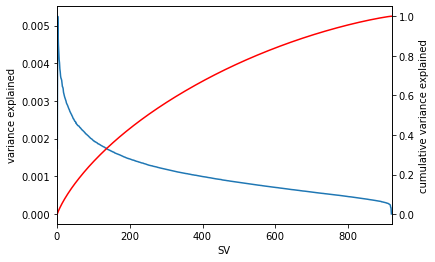

In [36]:
# using svd.explained_variance_ratio_
nssd = svd_model.explained_variance_ratio_


fig, ax = plt.subplots()
ax.plot(range(1, len(nssd)+1), nssd, '-', label='individual')
ax.set_xlim(0, len(nssd)+1)
ax.set_xlabel('SV')
ax.set_ylabel('variance explained')
ax = ax.twinx()
ax.plot(range(1, len(nssd)+1), nssd.cumsum(), 'r-', label='cumulative')
# ax.axhline(my_var, ls='--', color='g')
# ax.axvline(my_svs, ls='--', color='g')
ax.set_ylabel('cumulative variance explained');


Now rerunning SVD for minimum desired SVs

In [37]:
svs = np.array(nssd.cumsum())

# what is your ideal variance explained?
my_var = 0.9
my_svs = np.where(svs>= my_var)[0][0]
print(f"SV's to retain: {my_svs} for {my_var*100}% Explained Variance" )

SV's to retain: 693 for 90.0% Explained Variance


In [38]:
# SVD represent documents and terms in vectors 
# n_components guidance: ideally #number of words-1
#                        compromise is to start with 500 & trial/error

n_comp = my_svs

svd_model = TruncatedSVD(n_components=n_comp)
X_new = svd_model.fit_transform(X)
print("done!")

feature_names = vectorizer.get_feature_names()
Sigma = svd_model.singular_values_
V_T = svd_model.components_.T
nssd = svd_model.explained_variance_ratio_

done!


## Perform TFIDF & SVD for each of the months

Define function to perform Dimensionality Reduction across a list of corpus

In [39]:
def perform_dimreduc(corpus_list, my_var):
    """Perform TFDIF and TruncatedSVD on list of corpus
    
    Input:
    corpus_list: list of corpus
        if only 1 corpus, just pass as array of 1 element
    my_var: int between 0 to 1
        desired variance explained for SVD truncation
    """

    #for the timer thing
    from tqdm import tqdm
    
    # Adding new stop words
    newStopWords = ['writing', 'prompt', 'write', 'has', 
                    'just', 'ha', 'was', 'wa', 'did']
    my_stop_words = text.ENGLISH_STOP_WORDS.union(newStopWords)

    out = []
    for i, this_corpus in tqdm(enumerate(corpus_list)):
        print('Starting: ', i)
        
        dict_dimreduc = dict()
        
        # TFIDF proper
        vectorizer = TfidfVectorizer(
            stop_words = my_stop_words, # use custom list of words + english
            token_pattern=u'(?ui)\\b[a-z]+\\b',
        #     max_features= 50_000, # keep top 1000 terms, the higher the better
            max_df = 0.9, # remove words that appear in more than 90%
        #     min_df= 15,   # removing words that appear in less than X articles
        #     smooth_idf=True,
        #     ngram_range=(2,2)
        )

        X = vectorizer.fit_transform(this_corpus)
        print("After vectorizing the titles we have:")
        print(f'Rows = {X.shape[0]} and Words = {X.shape[1]}')

        # SVD first run
        n_comp = X.shape[1]-1
        svd_model = TruncatedSVD(n_components=n_comp)
        X_new = svd_model.fit_transform(X)
        nssd = svd_model.explained_variance_ratio_
    #     print("done! X_new shape is now: ", X_new.shape)

        # How many SVs to meet variance explained?
        svs = np.array(nssd.cumsum())
        my_svs = np.where(svs>= my_var)[0][0]
        print(f"SV's to retain:{my_svs} for {my_var*100}% Explained Variance")

        # SVD second run on desired my_svs based on variance explained
        svd_model = TruncatedSVD(n_components=my_svs)
        X_new = svd_model.fit_transform(X)
        print("SVD done!")

        dict_dimreduc['vectorizer'] = vectorizer
        dict_dimreduc['X'] = X
        dict_dimreduc['svd_model'] = svd_model
        dict_dimreduc['X_new'] = X_new
        dict_dimreduc['feature_names'] = vectorizer.get_feature_names()
        dict_dimreduc['Sigma'] = svd_model.singular_values_
        dict_dimreduc['V_T'] = svd_model.components_.T
        dict_dimreduc['nssd'] = svd_model.explained_variance_ratio_
        
        out.append(dict_dimreduc)
        
    return out

**EXECUTE:** Perform the Dimensionality reduction on `corpus_arr` with 0.9 explained variance

In [40]:
# Execute TFIDF, SVD with .9 explained variance 
# on all the months data

all_data = perform_dimreduc(corpus_arr, .9)

0it [00:00, ?it/s]

Starting:  0
After vectorizing the titles we have:
Rows = 919 and Words = 4873
SV's to retain:693 for 90.0% Explained Variance


1it [00:24, 24.54s/it]

SVD done!
Starting:  1
After vectorizing the titles we have:
Rows = 879 and Words = 4798
SV's to retain:671 for 90.0% Explained Variance


2it [00:47, 23.87s/it]

SVD done!
Starting:  2
After vectorizing the titles we have:
Rows = 924 and Words = 4689
SV's to retain:697 for 90.0% Explained Variance


3it [01:12, 24.17s/it]

SVD done!
Starting:  3
After vectorizing the titles we have:
Rows = 914 and Words = 4747
SV's to retain:689 for 90.0% Explained Variance


4it [01:37, 24.36s/it]

SVD done!


In [52]:
all_data[0]['vectorizer'] 
all_data[0]['X']
all_data[0]['svd_model']
all_data[0]['X_new']

# dict_dimreduc['vectorizer'] = vectorizer
# dict_dimreduc['X'] = X
# dict_dimreduc['svd_model'] = svd_model
# dict_dimreduc['X_new'] = X_new
# dict_dimreduc['feature_names'] = feature_names
# dict_dimreduc['Sigma'] = svd_model.singular_values_
# dict_dimreduc['V_T'] = svd_model.components_.T
# dict_dimreduc['nssd'] = svd_model.explained_variance_ratio_

all_data

[{'vectorizer': TfidfVectorizer(max_df=0.9,
                  stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                        'afterwards', 'again', 'against', 'all',
                                        'almost', 'alone', 'along', 'already',
                                        'also', 'although', 'always', 'am',
                                        'among', 'amongst', 'amoungst', 'amount',
                                        'an', 'and', 'another', 'any', 'anyhow',
                                        'anyone', 'anything', 'anyway',
                                        'anywhere', ...}),
                  token_pattern='(?ui)\\b[a-z]+\\b'),
  'X': <919x4873 sparse matrix of type '<class 'numpy.float64'>'
  	with 14441 stored elements in Compressed Sparse Row format>,
  'svd_model': TruncatedSVD(n_components=693),
  'X_new': array([[ 0.06604297,  0.00150682, -0.06250934, ...,  0.0549925 ,
           0.0300437 , -0.01577074],
 

**Visualize top SVs**

In [53]:
# for i in range(20):
#     fig, ax = plt.subplots()
#     order = np.argsort(np.abs(V_T[:, i]))[-10:]
#     ax.barh([feature_names[o] for o in order], V_T[order, i])
#     ax.set_title(f'SV{i+1}')

### Saving SVD results to file or retrieving from file

Save the resulting model & transformed matrix to pickle file.


In [55]:
# BE CAREFUL!
# Modify to True if you want to run the extraction again
overwrite = False

# Saving proper
if overwrite == True:

    #for each source file, print number of json objects extracted
    print(f"File: saving")

    # Write into a pickle file
    # Uncomment if rewriting files.
    with open(f"./data_postprocessed/svd_all_data.pkl","wb") as file:
        pickle.dump(all_data, file)

    print('done!')

**Optional:** Retrieve previously saved SVD results

In [40]:
# all_data = pd.read_pickle(f"./data_postprocessed/svd_all_data.pkl")
# all_data

# Clustering

In [42]:
# FUNCTIONS

def plot_cluster(X, y_predict, feature_names, this_month):
    """Plot the words that can be found in the cluster titles
    
    Input:
    df_c: tfid"""
    from wordcloud import WordCloud, STOPWORDS
    import math
    
    # Create df mapping TFIDF vectorized and the cluster assignment
    df_c = pd.DataFrame(X.toarray())
    df_c['cluster'] = y_predict
    
    c = list(set(y_predict))
    rows = math.ceil(len(c)/3)
    cols = 3
    fig, ax = plt.subplots(rows,cols, 
                           figsize=(15,5*rows), 
                           constrained_layout=True)
    # remove borders
    for a in range(0,rows*cols):
        ax[a//3, a%3].axis('off')
        ax[a//3, a%3].get_xaxis().set_ticks([])
        ax[a//3, a%3].get_yaxis().set_ticks([])
        
    # For each of the clusters
    for i, each in enumerate(c):
        c_sum = df_c[df_c['cluster']==c[i]].sum(axis=0)
        data_cN = []
        for col, term in enumerate(feature_names):
            data_cN.append((term, c_sum[col]))

        ranking = pd.DataFrame(data_cN, columns=['term','rank'])
        rank1 = ranking.sort_values('rank', ascending=False)
        rank1[:500]
        

        df_f = rank1.set_index('term')

        # Generate wordcloud
        wordcloud = WordCloud(width = 300, height = 200, random_state=1, 
                              background_color='#323672', 
                              colormap='Set1', 
                              collocations=False, 
                              stopwords = STOPWORDS)
        wordcloud.generate_from_frequencies(frequencies=df_f['rank'])
        x = i//3
        y = i%3
        ax[x, y].set_title(f"Words for cluster: {each}")
        # Display image
        ax[x, y].imshow(wordcloud) 
        # No axis details
        ax[x, y].axis("off");
    plt.suptitle(f"Clusters for {this_month}")
#     fig.set_title()

## Ward + Cosine for each month

In [106]:
# all_data[0], January 2020

# REFERENCE POSSIBLE FIELDS
# all_data[0]['vectorizer'] = vectorizer
# all_data[0]['X'] = X
# all_data[0]['svd_model'] = svd_model
# all_data[0]['X_new'] = X_new
# all_data[0]['feature_names'] = feature_names
# all_data[0]['Sigma'] = svd_model.singular_values_
# all_data[0]['V_T'] = svd_model.components_.T
# all_data[0]['nssd'] = svd_model.explained_variance_ratio_


### **January 2020**

Text(0.5, 0.98, 'PCAs of dataset')

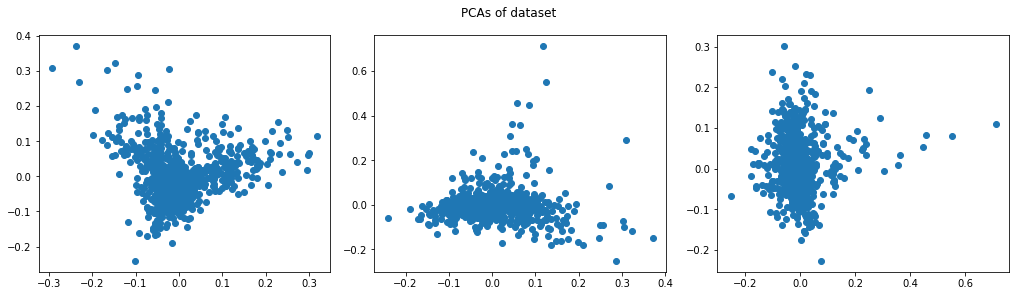

In [43]:
# Let's do PCA just to prep for visualization
from sklearn.decomposition import PCA

X_pca = PCA(n_components=4, random_state=1337).fit_transform(all_data[0]['X_new'])

fig, ax = plt.subplots(1,3, figsize=(14,4), constrained_layout=True)
ax[0].scatter(X_pca[:,0], X_pca[:,1])
ax[1].scatter(X_pca[:,1], X_pca[:,2])
ax[2].scatter(X_pca[:,2], X_pca[:,3])

plt.suptitle(f"PCAs of dataset")

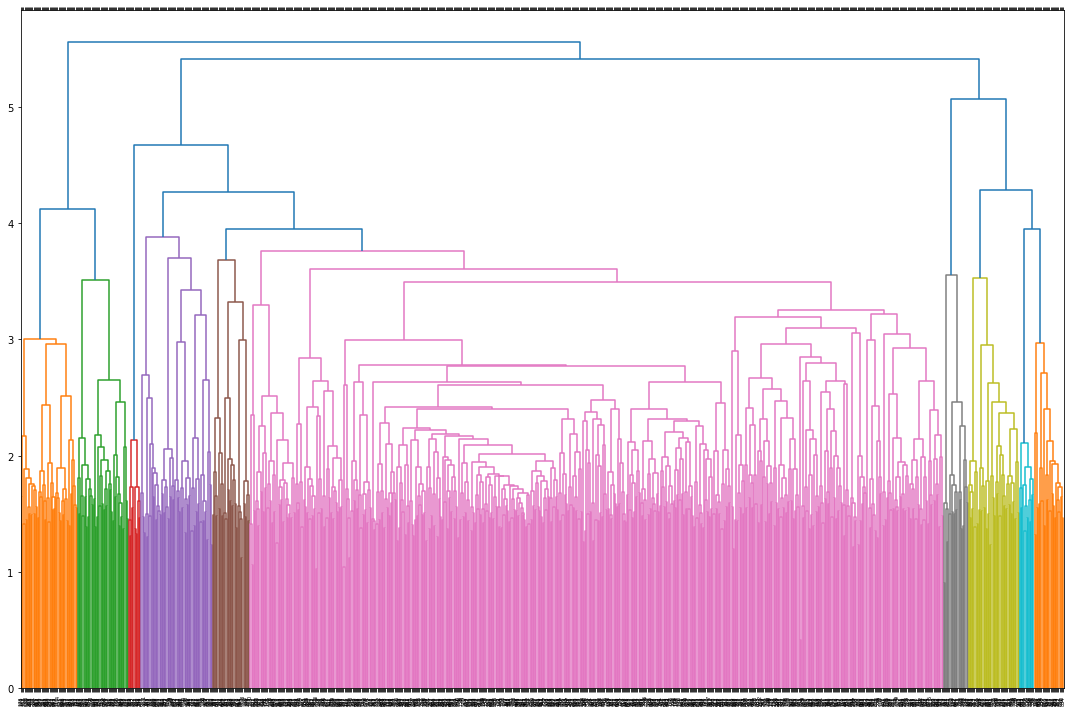

In [44]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import ward, dendrogram

dist = 1 - cosine_similarity(all_data[0]['X_new'])
linkage_matrix = ward(dist)

fig, ax = plt.subplots(figsize=(15, 10)) # set size
ax = dendrogram(linkage_matrix);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

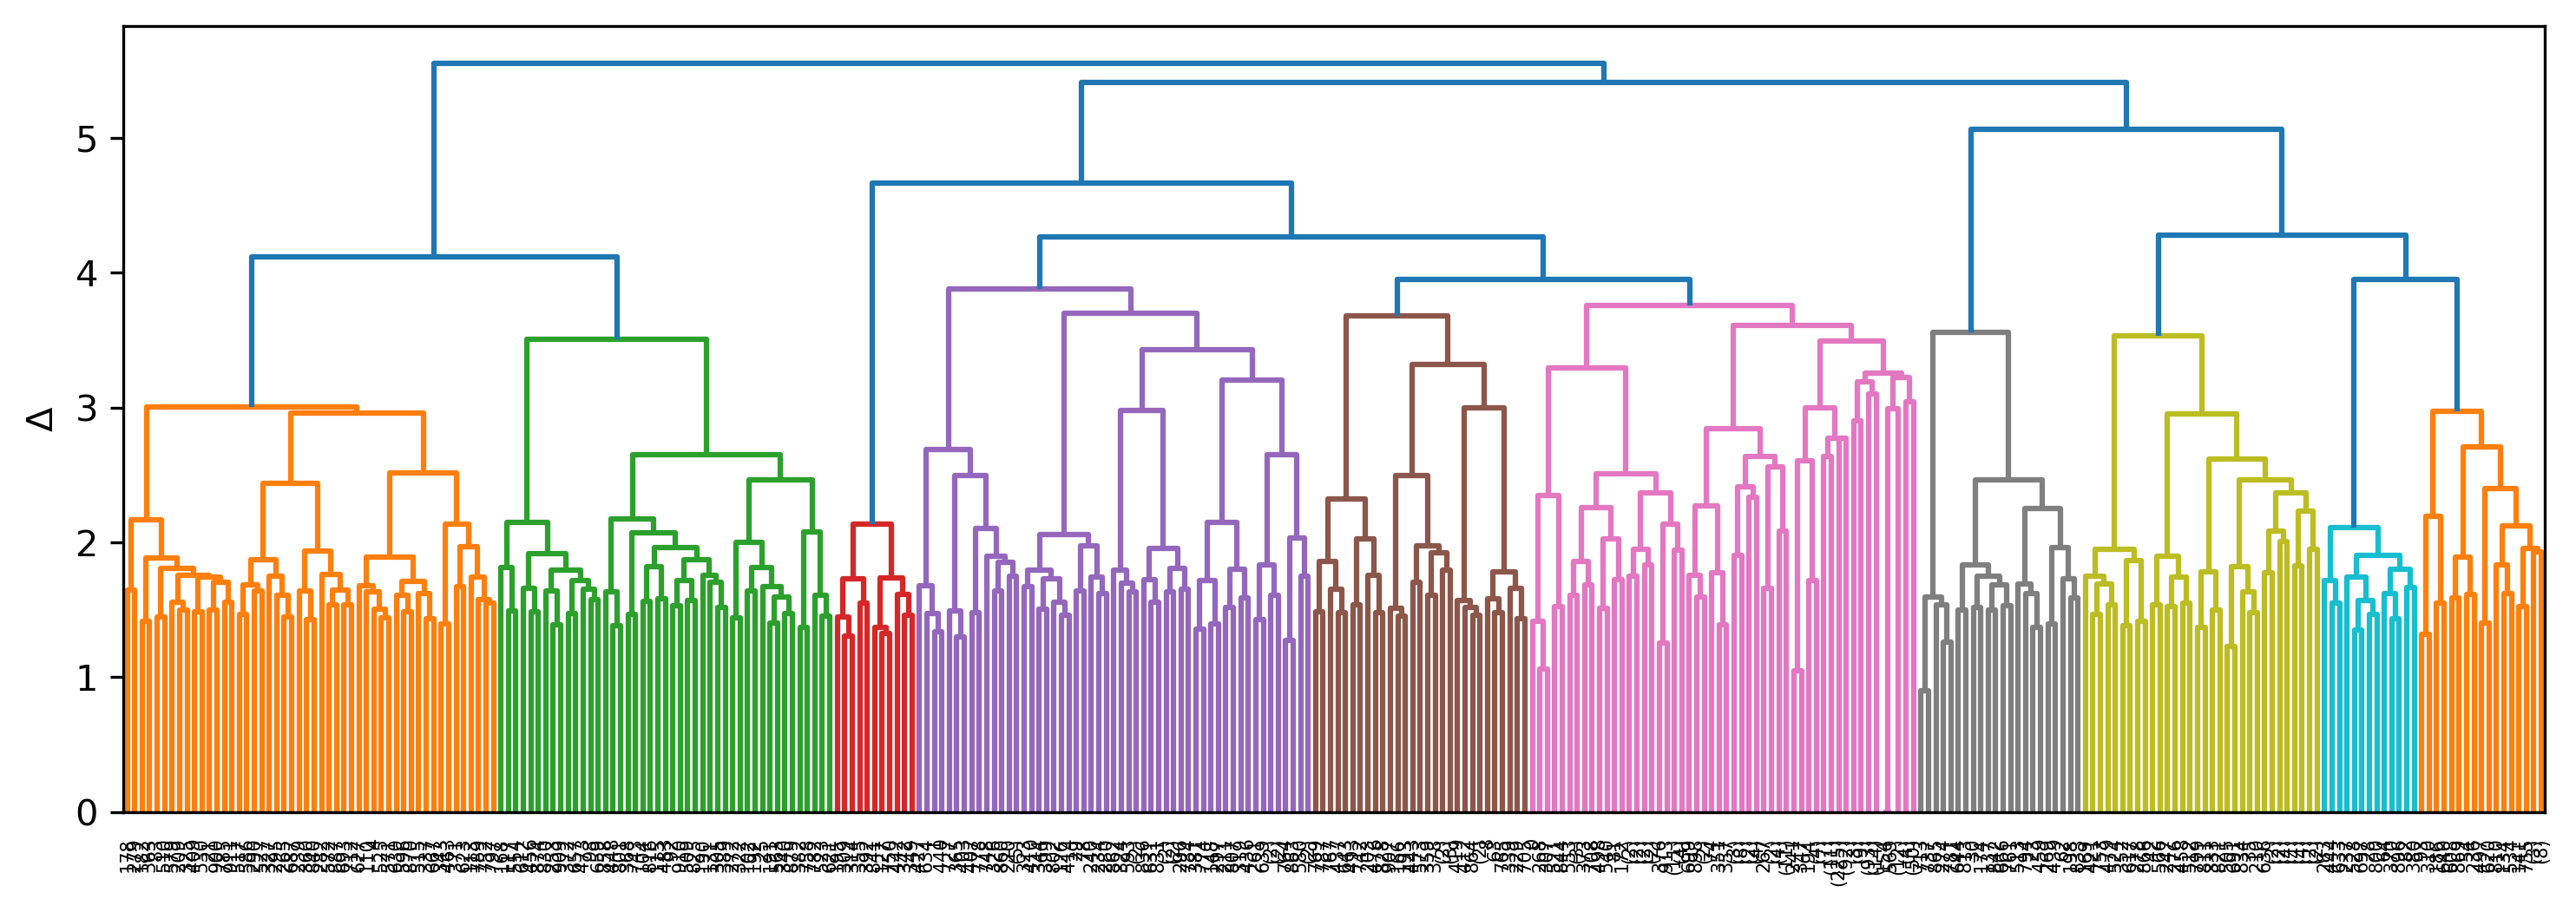

In [45]:
# What an ugly dendogram!
# Let's truncate on p=10

fig, ax = plt.subplots(figsize=(12,4), dpi=300)
dn = dendrogram(linkage_matrix, ax=ax, truncate_mode='level', p=10)
ax.set_ylabel(r'$\Delta$');

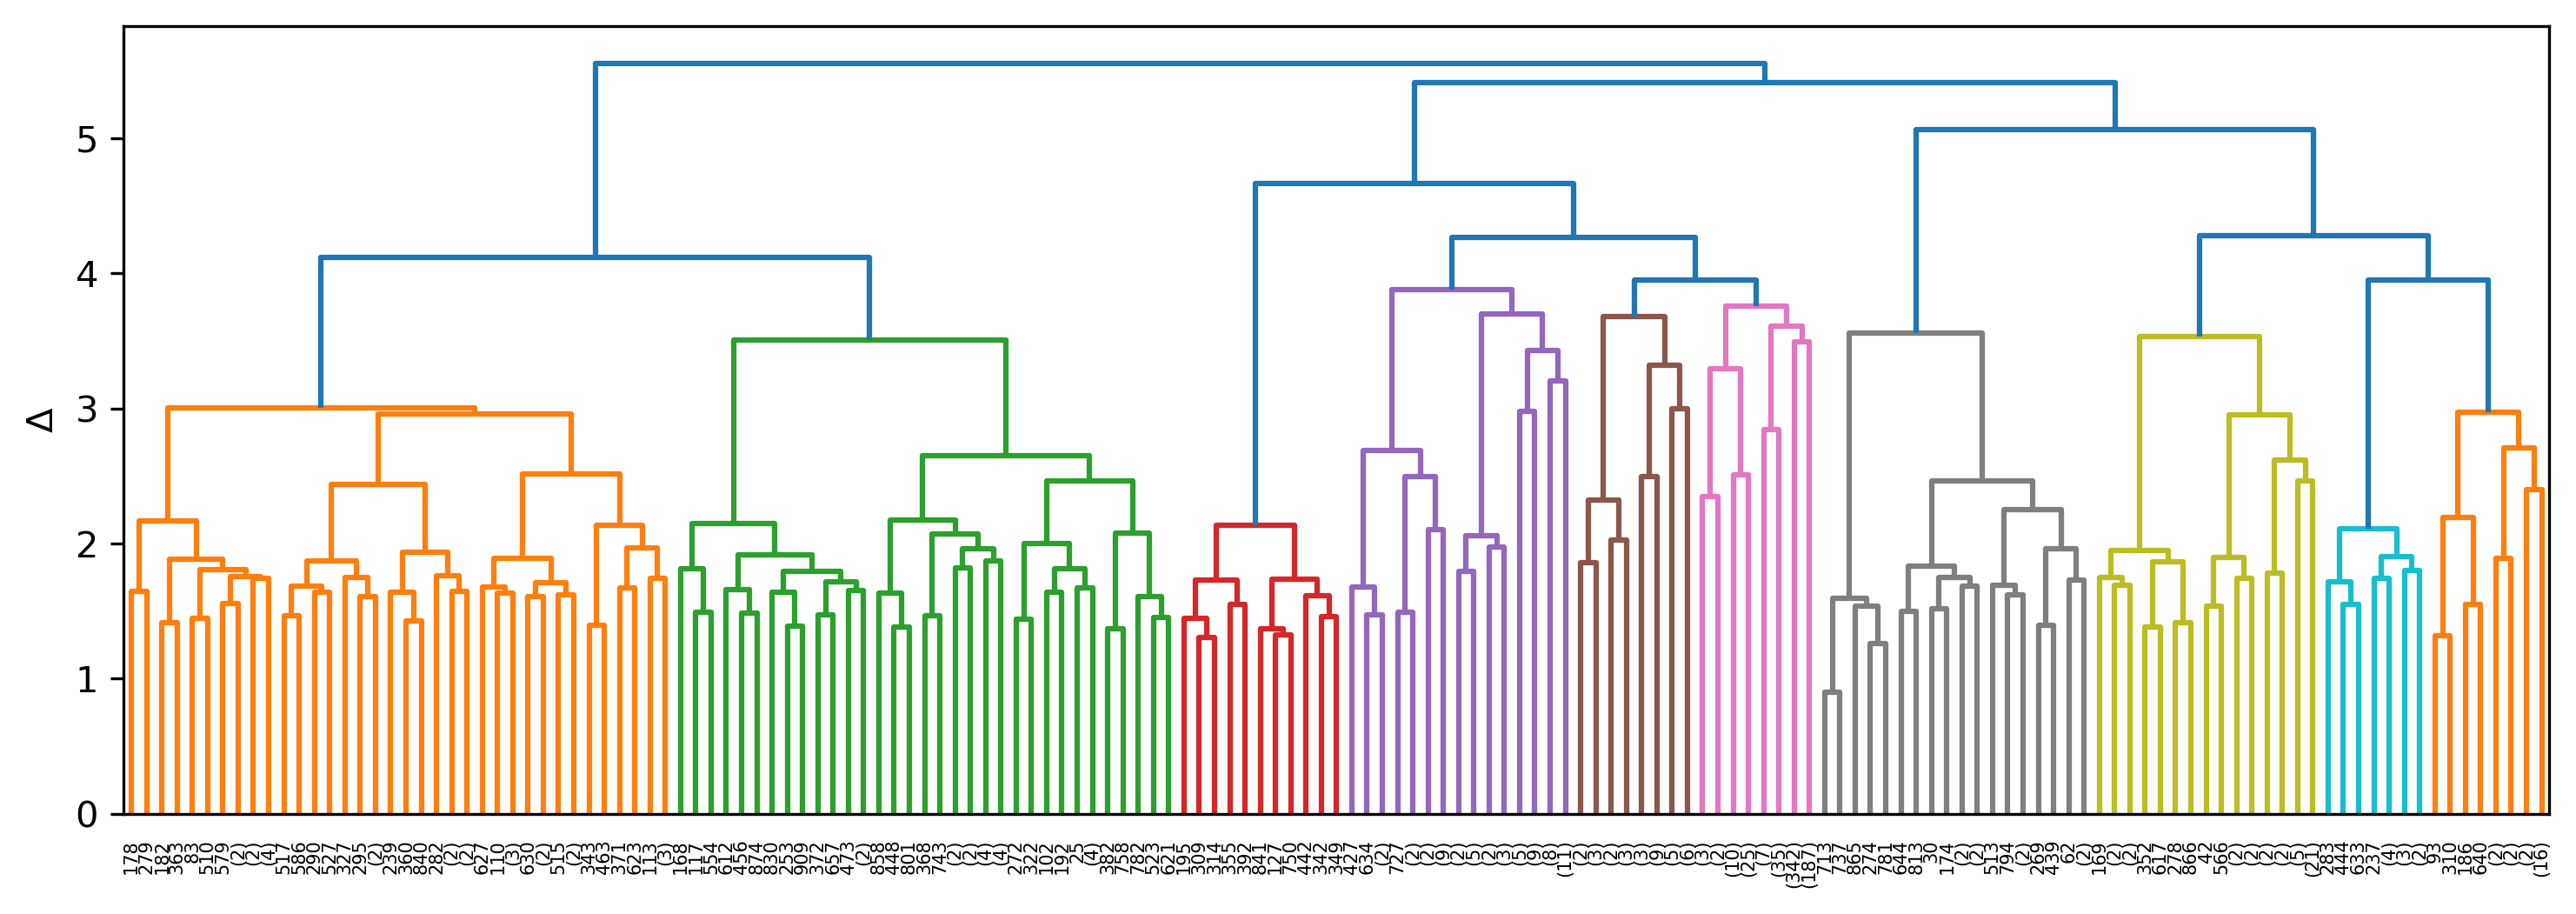

In [46]:
# What an ugly dendogram!
# Let's truncate on different p=7

fig, ax = plt.subplots(figsize=(12,4), dpi=300)
dn = dendrogram(linkage_matrix, ax=ax, truncate_mode='level', p=7)
ax.set_ylabel(r'$\Delta$');

Based on above dendograms, choose ```thres```.  We can try on that then do EDA if the SVs for those in the cluster make sense

Shape  (919, 4874)


7     611
1      50
2      45
5      45
9      45
6      33
11     26
8      22
4      18
10     13
3      11
Name: cluster, dtype: int64

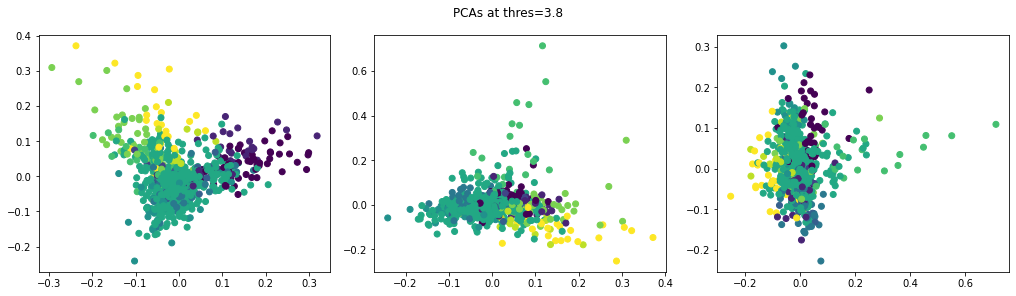

In [47]:
# Let's visualize on the 2 PCs
# color represents the cluster given the specified threshold

# Threshold:
thres = 3.8

from scipy.cluster.hierarchy import fcluster
y_predict = fcluster(linkage_matrix, t=thres, criterion='distance')

fig, ax = plt.subplots(1,3, figsize=(14,4), constrained_layout=True)
ax[0].scatter(X_pca[:,0], X_pca[:,1], c=y_predict)
ax[1].scatter(X_pca[:,1], X_pca[:,2], c=y_predict)
ax[2].scatter(X_pca[:,2], X_pca[:,3], c=y_predict)
plt.suptitle(f"PCAs at thres={thres}")


df_clustered = pd.DataFrame(all_data[0]['X'].toarray())
df_clustered['cluster'] = y_predict
# display(df_clustered.head())
print("Shape ", df_clustered.shape)
df_clustered['cluster'].value_counts()

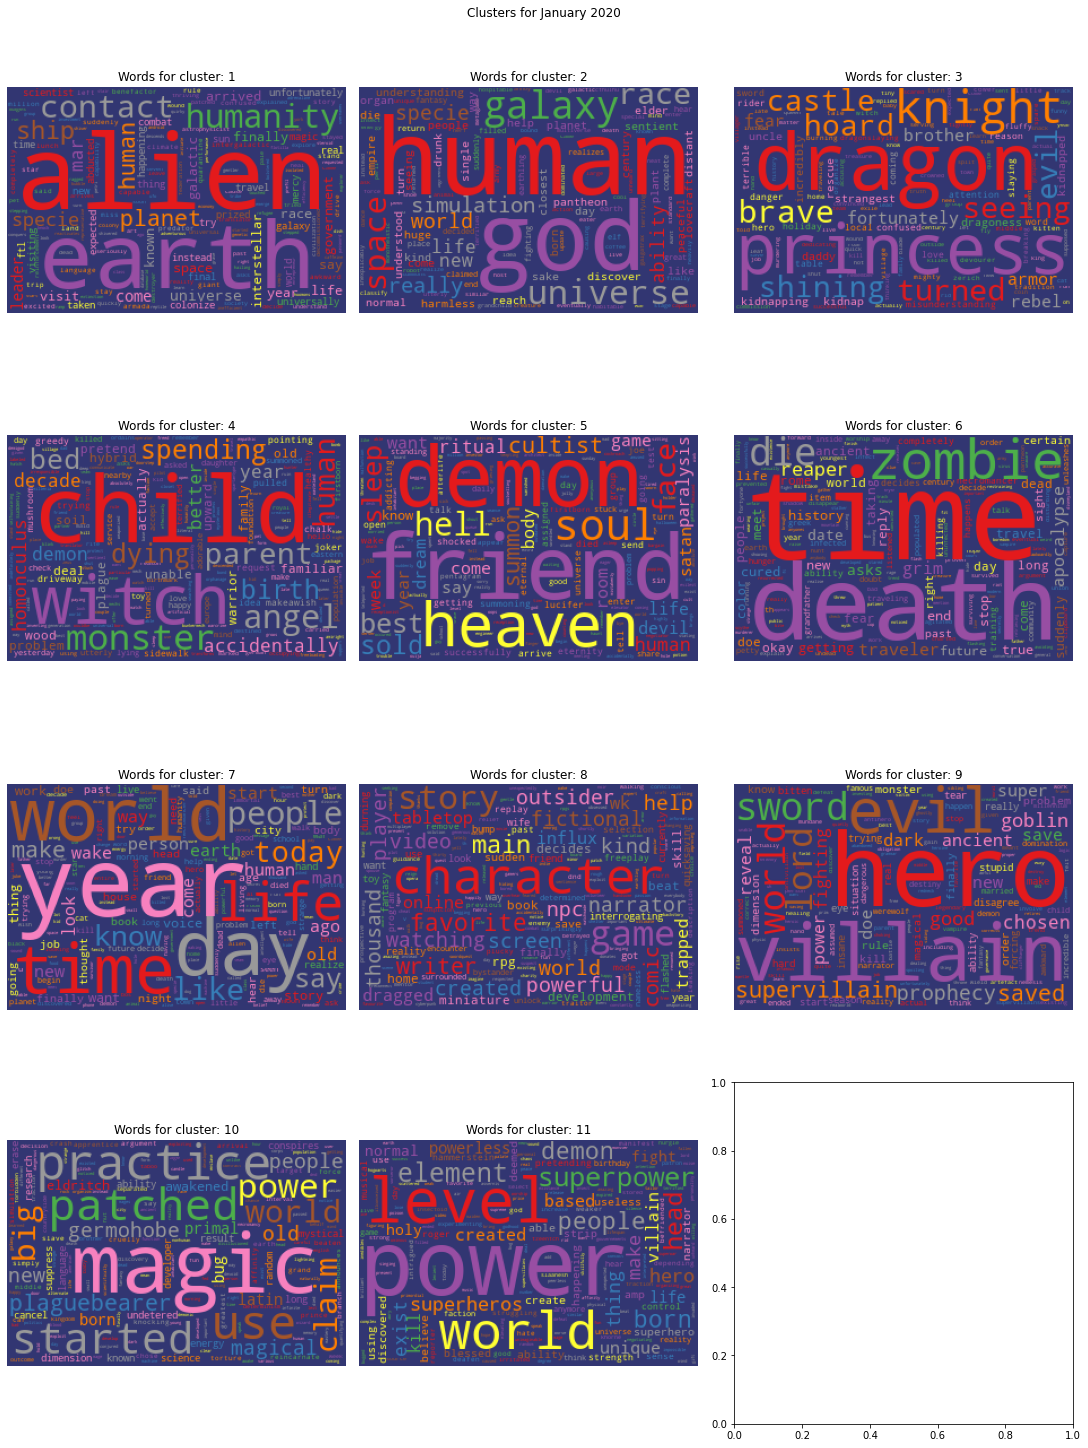

In [48]:
plot_cluster(all_data[0]['X'], y_predict, all_data[0]['feature_names'], 'January 2020')

Save the clustering results to file:

In [49]:
cluster1 = {
    'linkage_matrix': linkage_matrix,
    'y_predict':  y_predict
           }

# BE CAREFUL!
# Modify to True if you want to run the extraction again
overwrite = False

# Saving proper
if overwrite == True:

    with open(f"./data_postprocessed/cluster1.pkl","wb") as file:
        pickle.dump(cluster1, file)

### **February 2020**

Text(0.5, 0.98, 'PCAs of dataset')

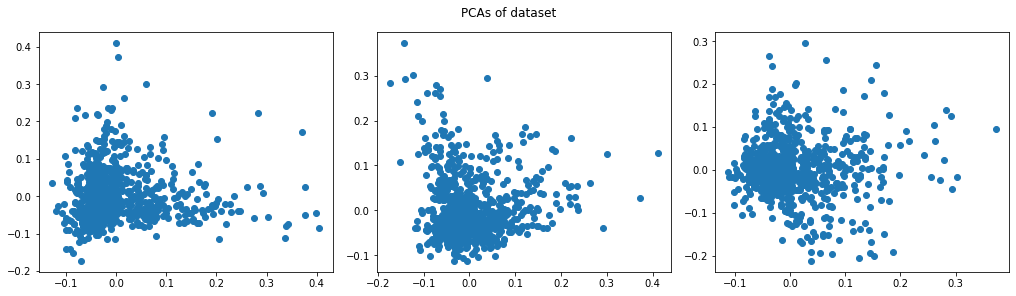

In [175]:
# Let's do PCA just to prep for visualization
from sklearn.decomposition import PCA

X_pca = PCA(n_components=4, random_state=1337).fit_transform(all_data[1]['X_new'])

fig, ax = plt.subplots(1,3, figsize=(14,4), constrained_layout=True)
ax[0].scatter(X_pca[:,0], X_pca[:,1])
ax[1].scatter(X_pca[:,1], X_pca[:,2])
ax[2].scatter(X_pca[:,2], X_pca[:,3])

plt.suptitle(f"PCAs of dataset")

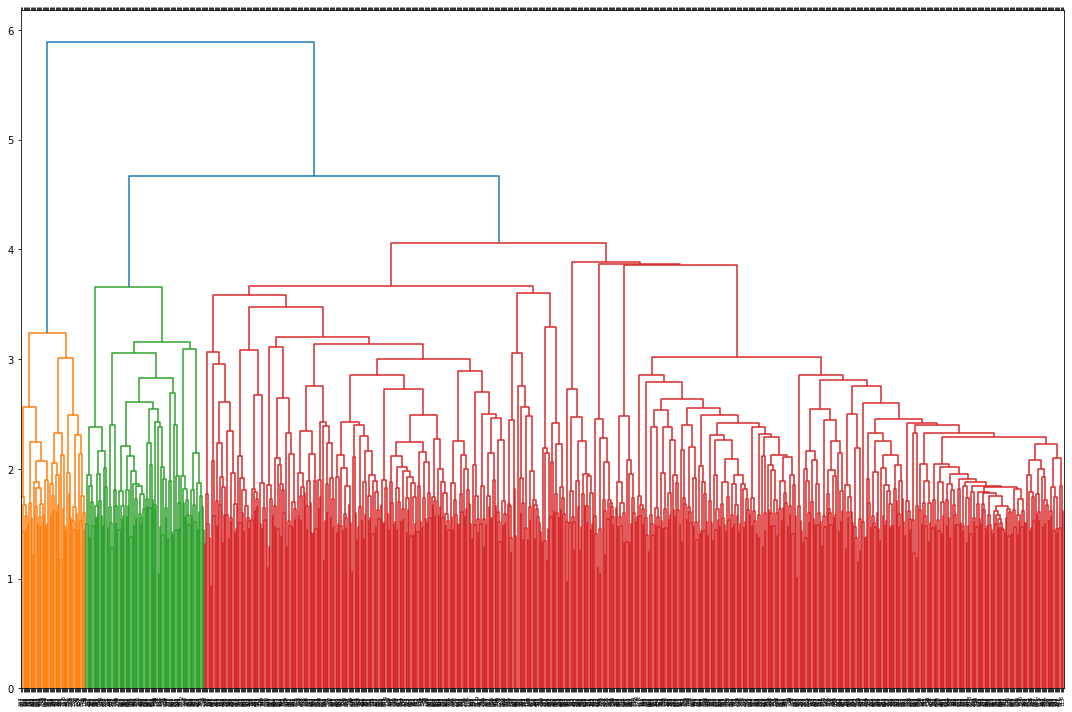

In [176]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import ward, dendrogram

dist = 1 - cosine_similarity(all_data[1]['X_new'])
linkage_matrix = ward(dist)

fig, ax = plt.subplots(figsize=(15, 10)) # set size
ax = dendrogram(linkage_matrix);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

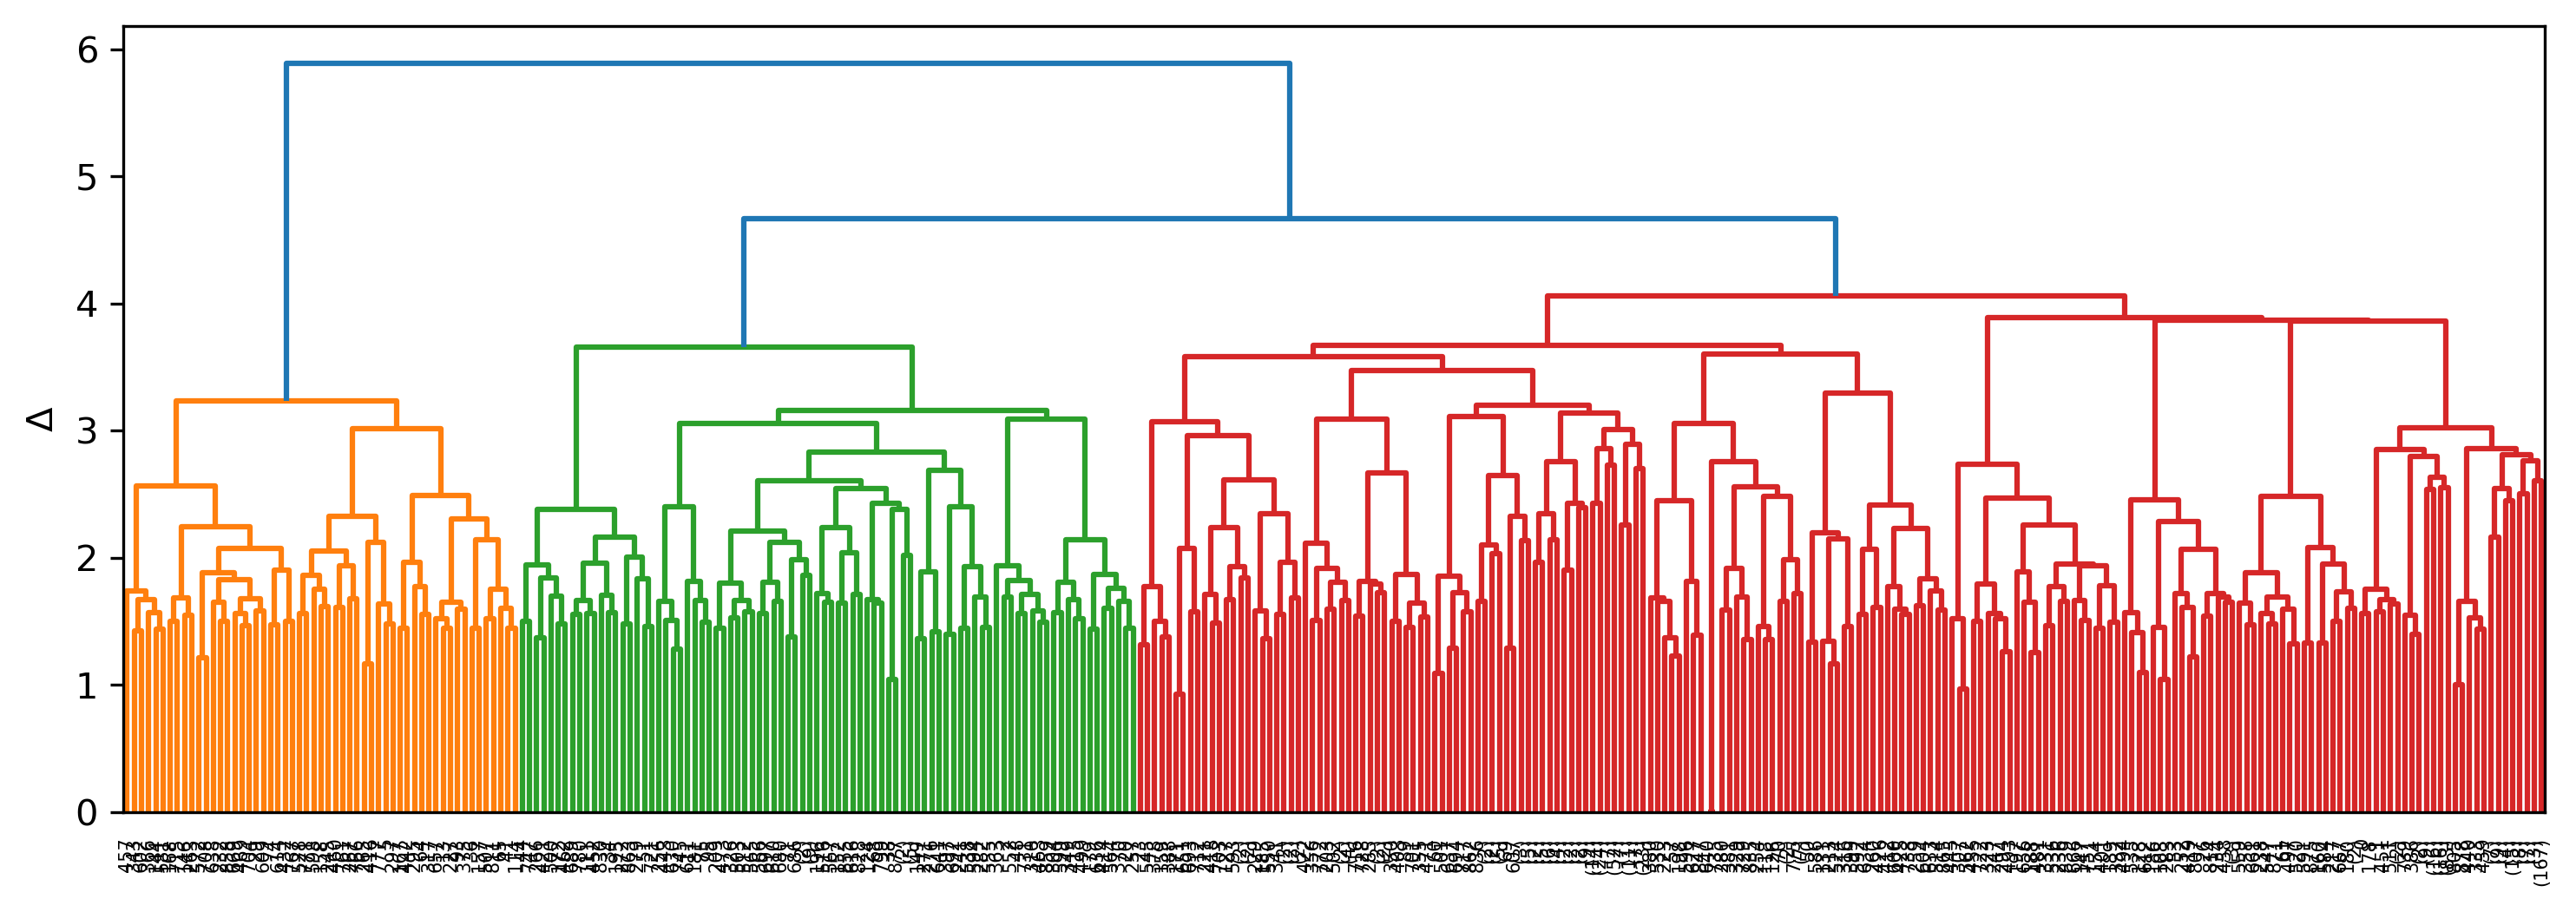

In [177]:
# What an ugly dendogram!
# Let's truncate on p=10

fig, ax = plt.subplots(figsize=(12,4), dpi=300)
dn = dendrogram(linkage_matrix, ax=ax, truncate_mode='level', p=10)
ax.set_ylabel(r'$\Delta$');

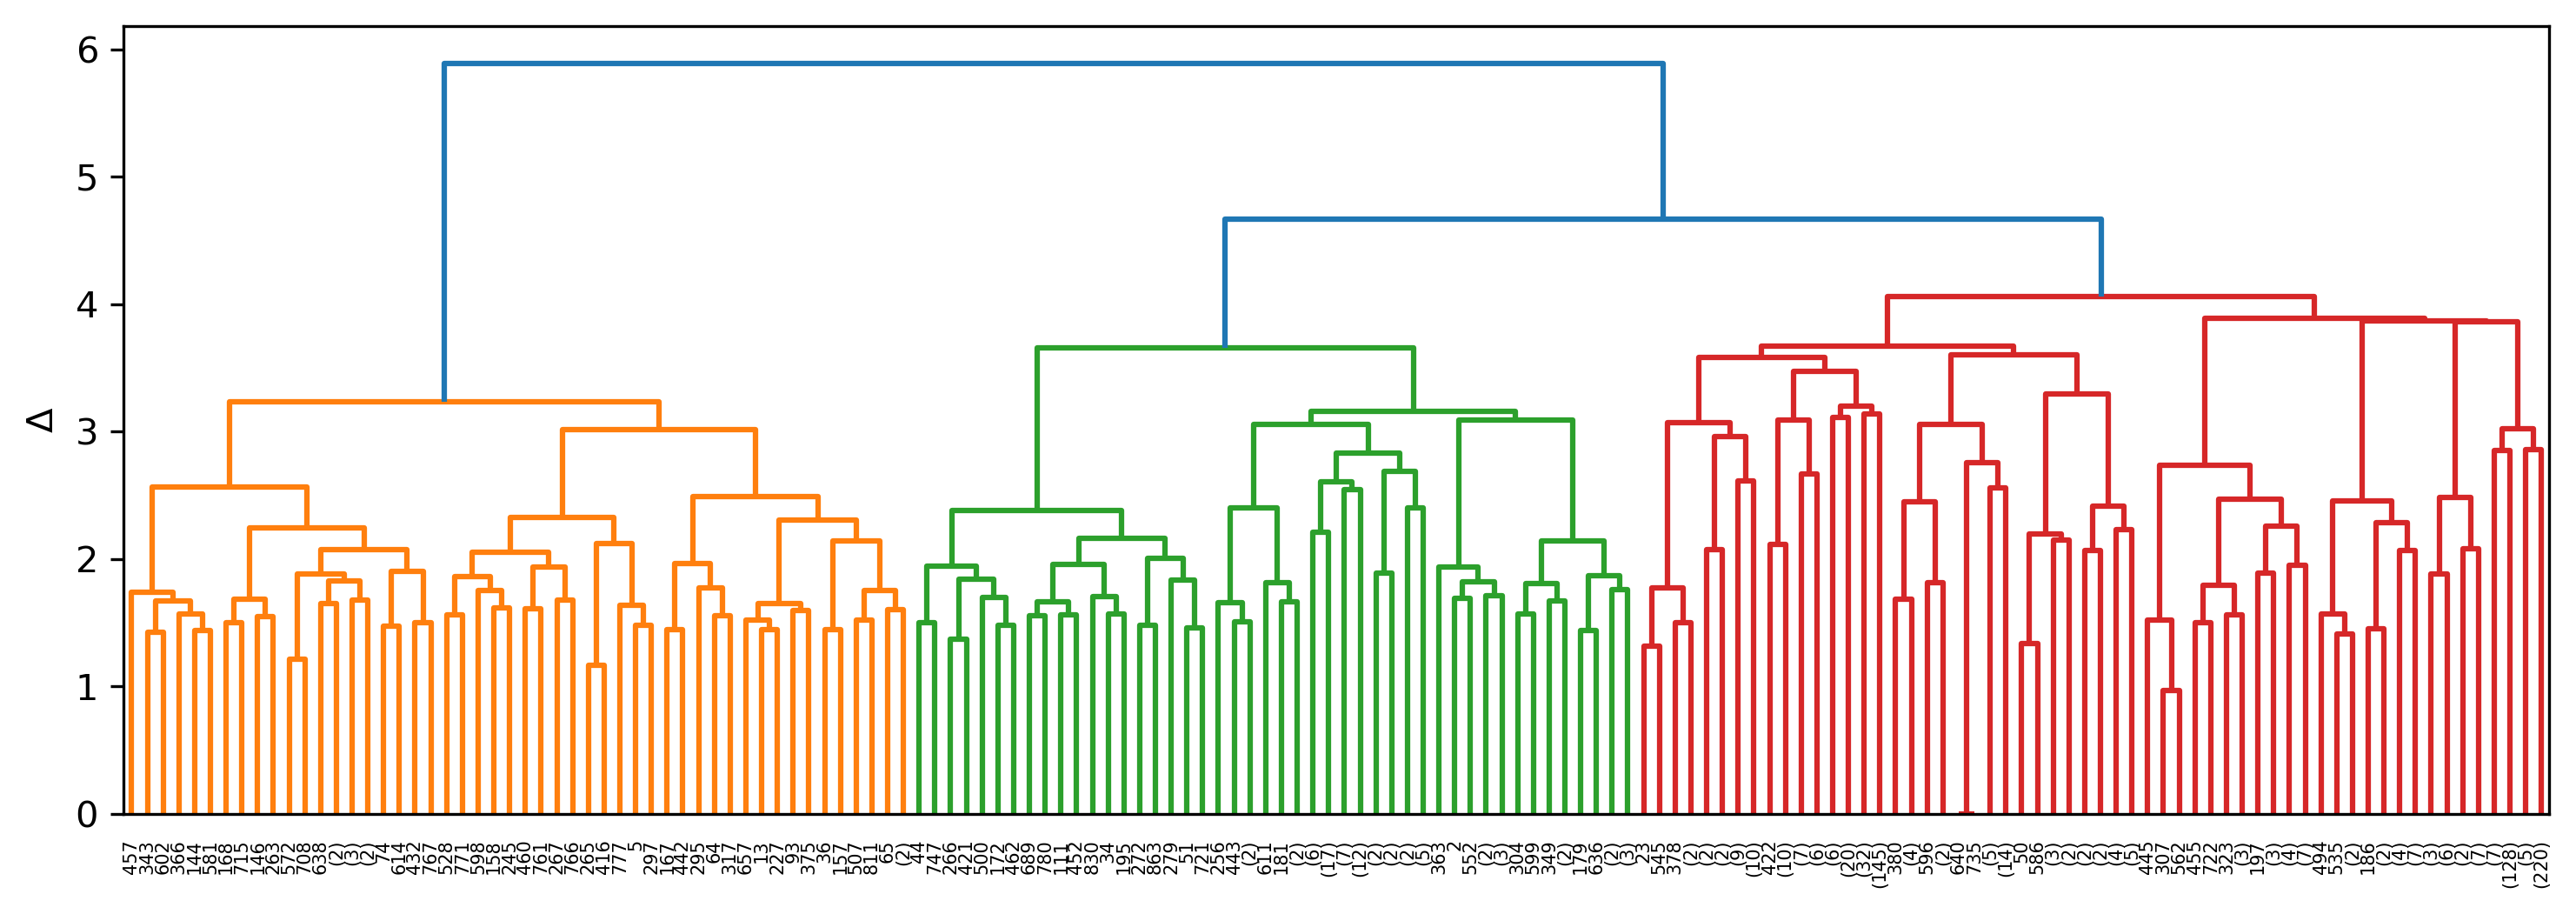

In [178]:
# What an ugly dendogram!
# Let's truncate on different p=7

fig, ax = plt.subplots(figsize=(12,4), dpi=300)
dn = dendrogram(linkage_matrix, ax=ax, truncate_mode='level', p=7)
ax.set_ylabel(r'$\Delta$');

Based on above dendograms, choose ```thres```.  We can try on that then do EDA if the SVs for those in the cluster make sense

Shape  (879, 4799)


11    360
5     227
3      81
1      55
6      29
4      28
8      24
7      20
2      19
9      18
10     18
Name: cluster, dtype: int64

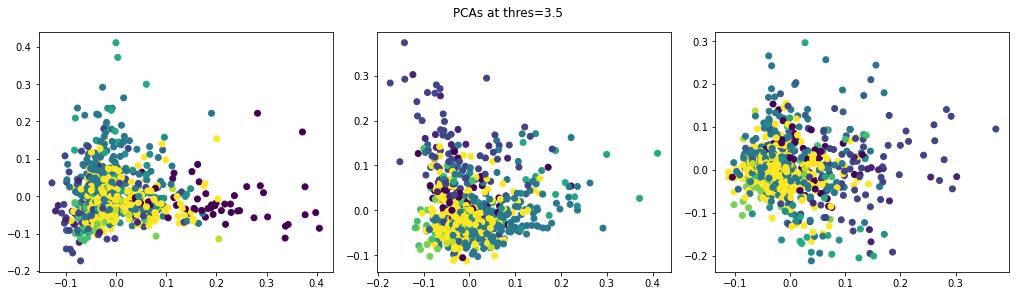

In [179]:
# Let's visualize on the 2 PCs
# color represents the cluster given the specified threshold

# Threshold:
thres = 3.5

from scipy.cluster.hierarchy import fcluster
y_predict = fcluster(linkage_matrix, t=thres, criterion='distance')

fig, ax = plt.subplots(1,3, figsize=(14,4), constrained_layout=True)
ax[0].scatter(X_pca[:,0], X_pca[:,1], c=y_predict)
ax[1].scatter(X_pca[:,1], X_pca[:,2], c=y_predict)
ax[2].scatter(X_pca[:,2], X_pca[:,3], c=y_predict)
plt.suptitle(f"PCAs at thres={thres}")


df_clustered = pd.DataFrame(all_data[1]['X'].toarray())
df_clustered['cluster'] = y_predict
# display(df_clustered.head())
print("Shape ", df_clustered.shape)
df_clustered['cluster'].value_counts()

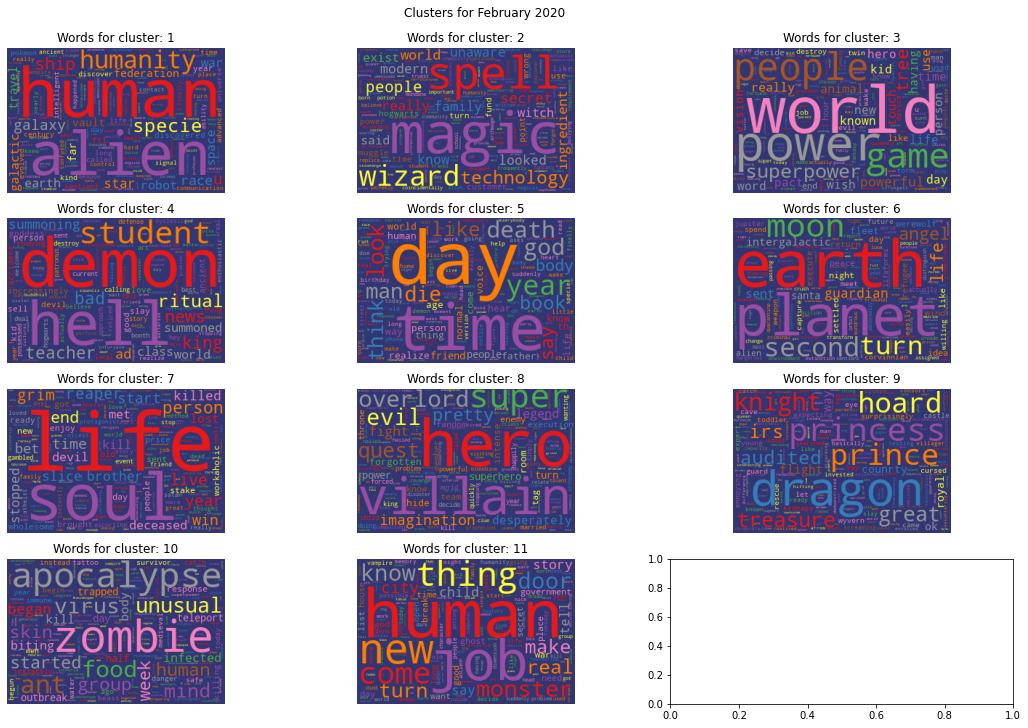

In [180]:
plot_cluster(all_data[1]['X'], y_predict, all_data[1]['feature_names'], 'February 2020')

Save clustering results to file

In [ ]:
cluster2 = {
    'linkage_matrix': linkage_matrix,
    'y_predict':  y_predict
           }

# BE CAREFUL!
# Modify to True if you want to run the extraction again
overwrite = False

# Saving proper
if overwrite == True:

    with open(f"./data_postprocessed/cluster2.pkl","wb") as file:
        pickle.dump(cluster2, file)

### **March 2020**

Text(0.5, 0.98, 'PCAs of dataset')

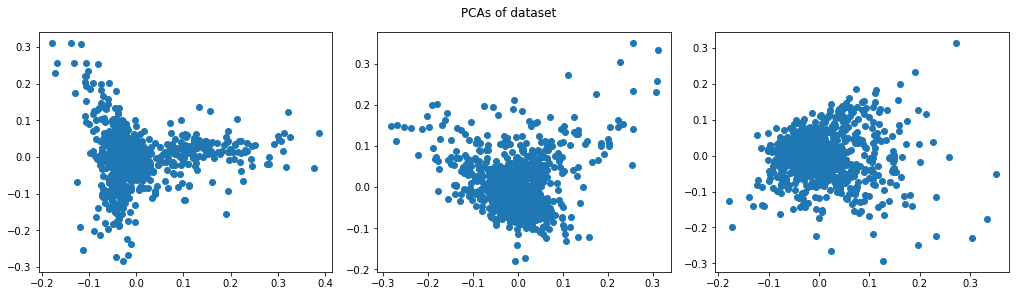

In [181]:
# Let's do PCA just to prep for visualization
from sklearn.decomposition import PCA

X_pca = PCA(n_components=4, random_state=1337).fit_transform(all_data[2]['X_new'])

fig, ax = plt.subplots(1,3, figsize=(14,4), constrained_layout=True)
ax[0].scatter(X_pca[:,0], X_pca[:,1])
ax[1].scatter(X_pca[:,1], X_pca[:,2])
ax[2].scatter(X_pca[:,2], X_pca[:,3])

plt.suptitle(f"PCAs of dataset")

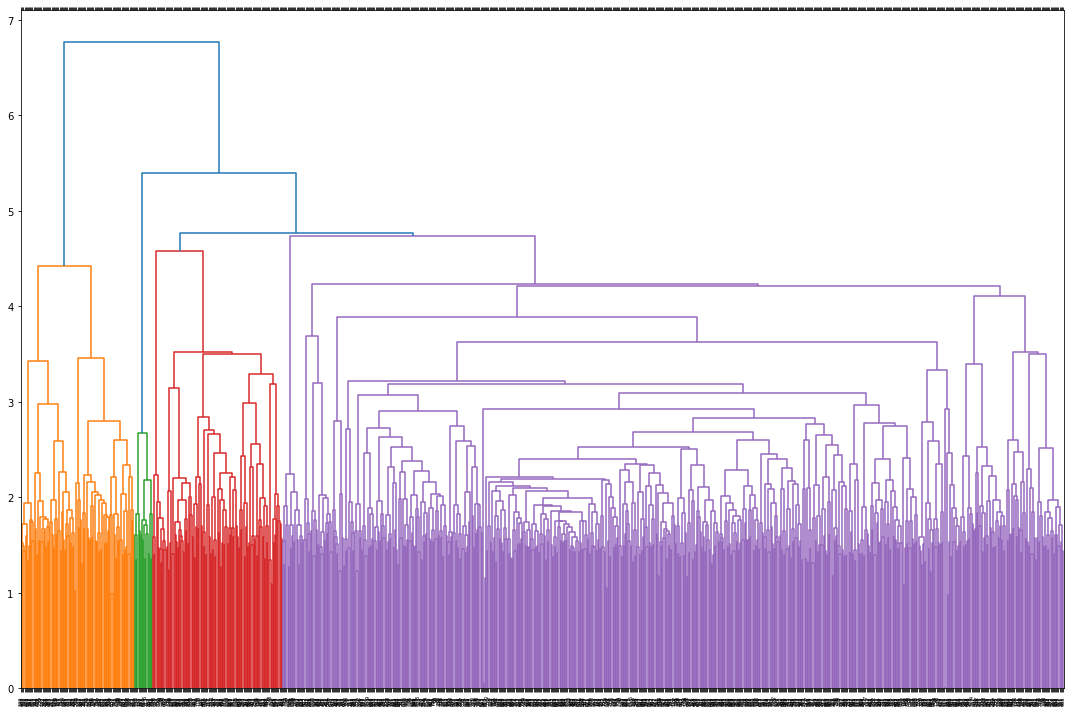

In [182]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import ward, dendrogram

dist = 1 - cosine_similarity(all_data[2]['X_new'])
linkage_matrix = ward(dist)

fig, ax = plt.subplots(figsize=(15, 10)) # set size
ax = dendrogram(linkage_matrix);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

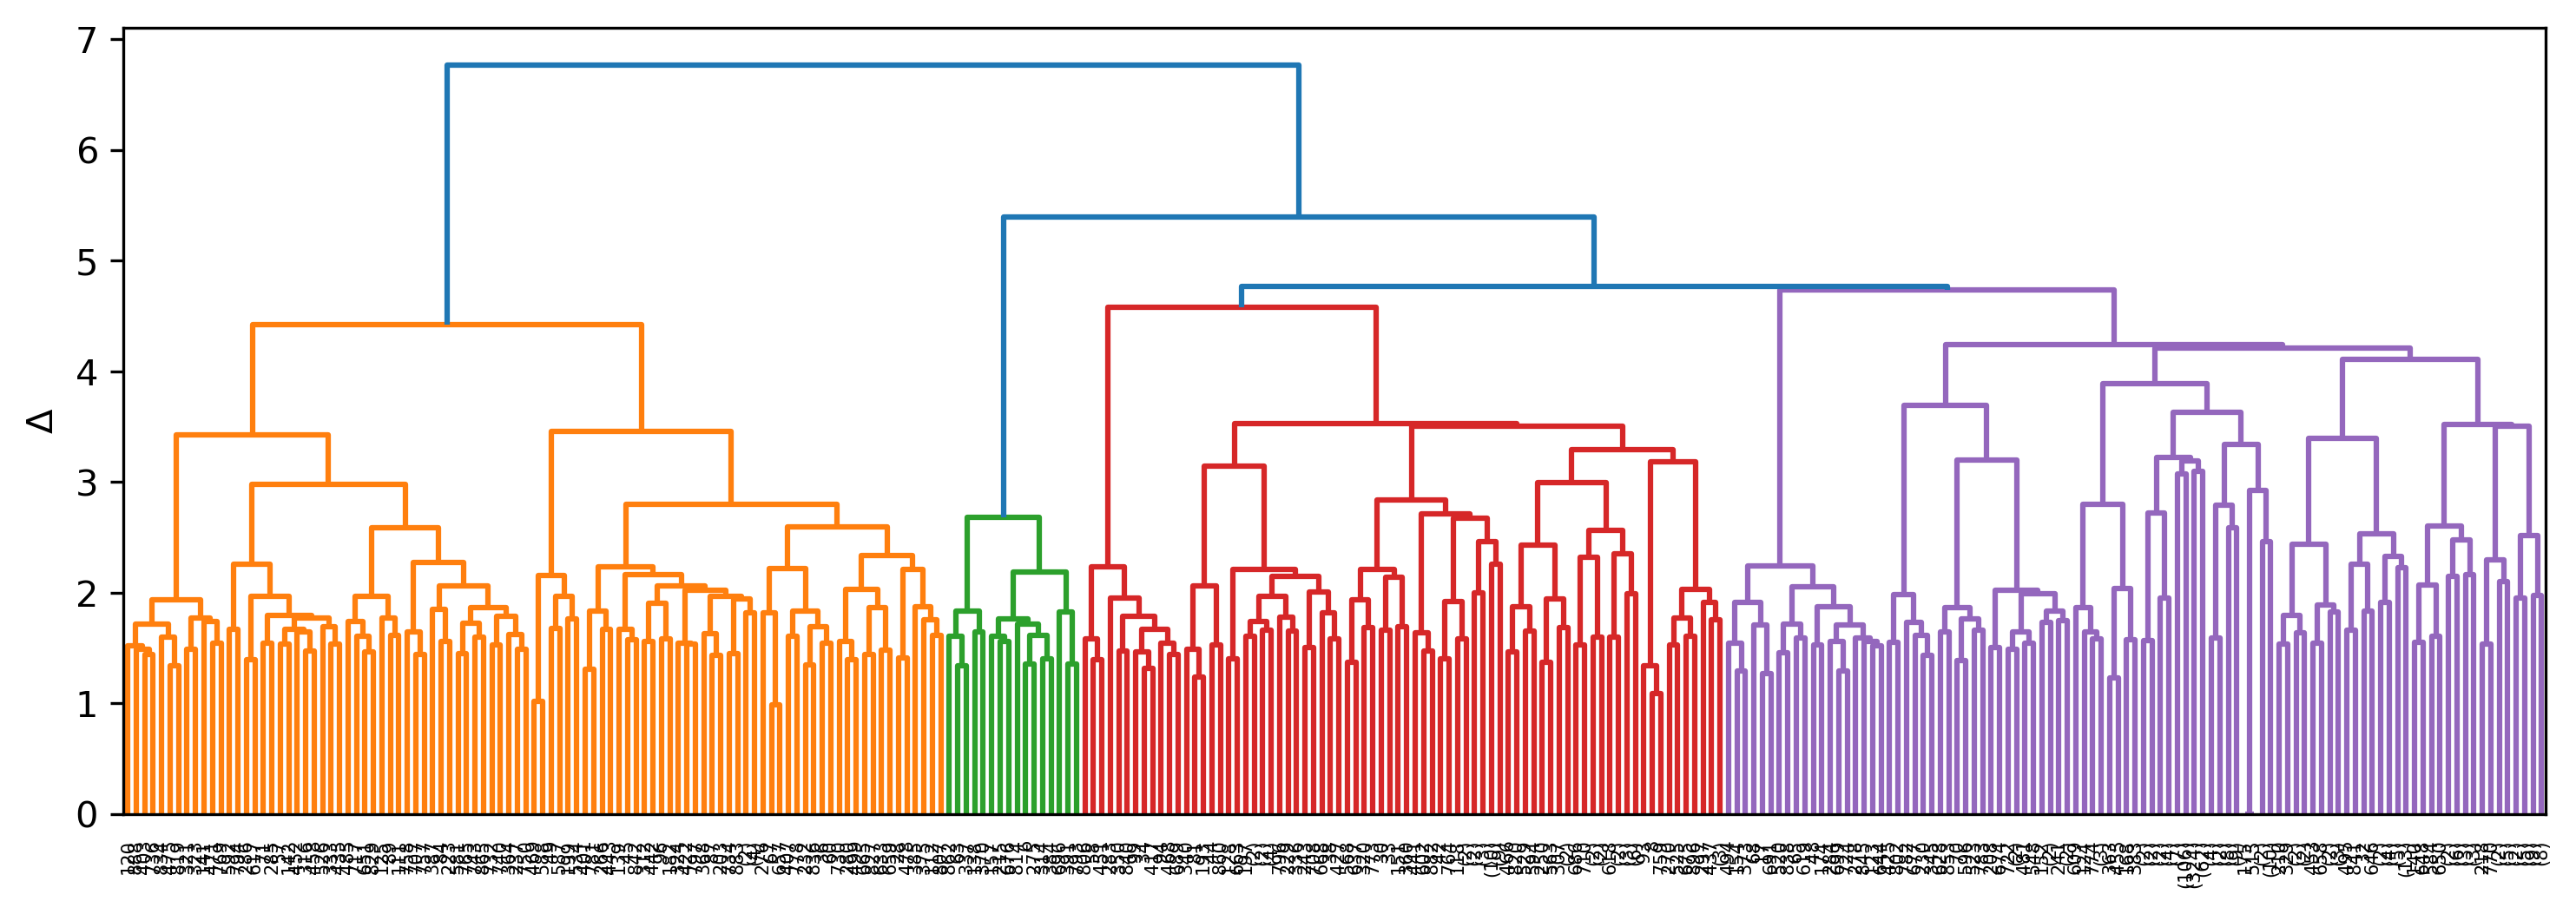

In [183]:
# What an ugly dendogram!
# Let's truncate on p=10

fig, ax = plt.subplots(figsize=(12,4), dpi=300)
dn = dendrogram(linkage_matrix, ax=ax, truncate_mode='level', p=10)
ax.set_ylabel(r'$\Delta$');

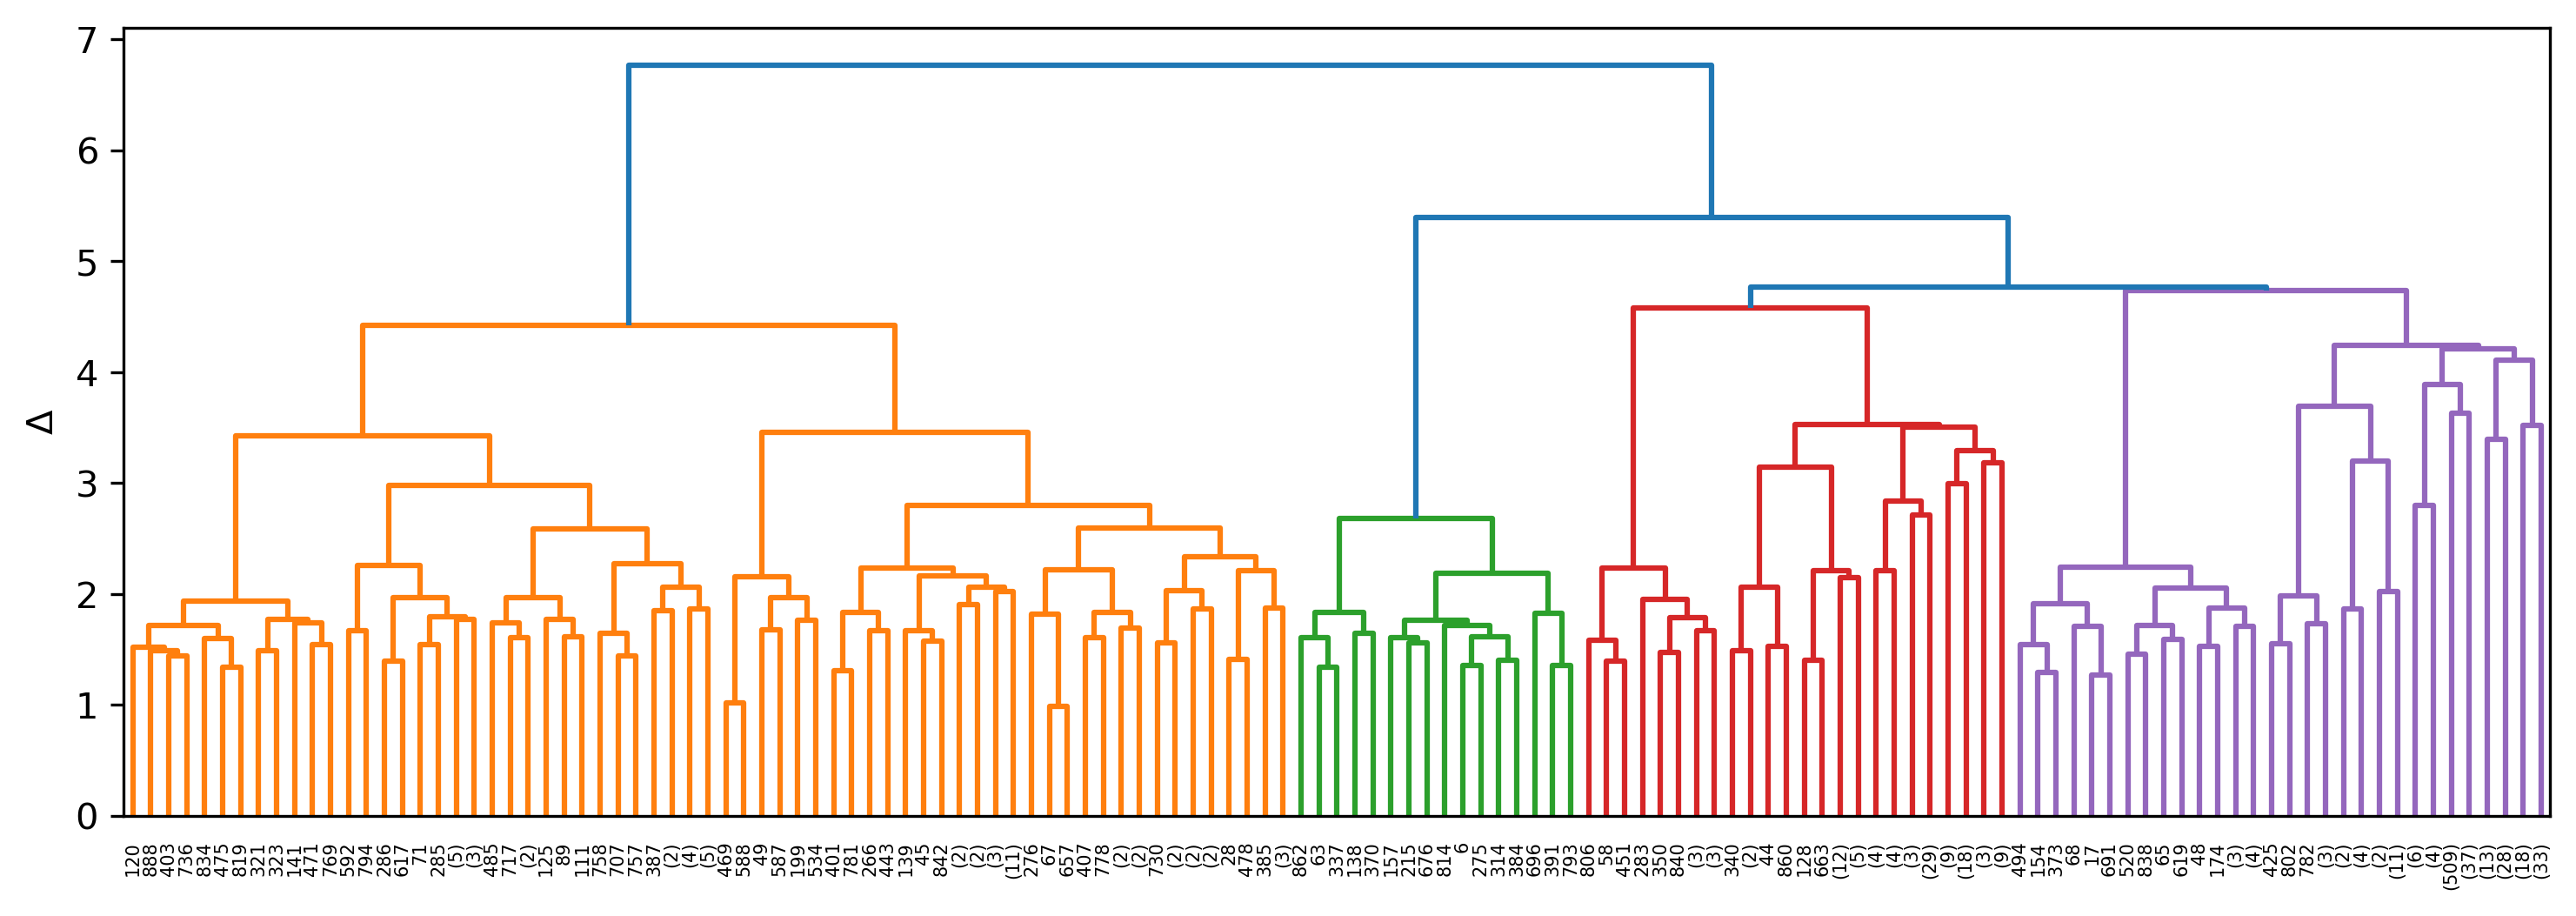

In [184]:
# What an ugly dendogram!
# Let's truncate on different p=7

fig, ax = plt.subplots(figsize=(12,4), dpi=300)
dn = dendrogram(linkage_matrix, ax=ax, truncate_mode='level', p=7)
ax.set_ylabel(r'$\Delta$');

Based on above dendograms, choose ```thres```.  We can try on that then do EDA if the SVs for those in the cluster make sense

Shape  (924, 4690)


8     556
5     103
2      53
10     51
1      48
9      41
7      25
6      19
3      16
4      12
Name: cluster, dtype: int64

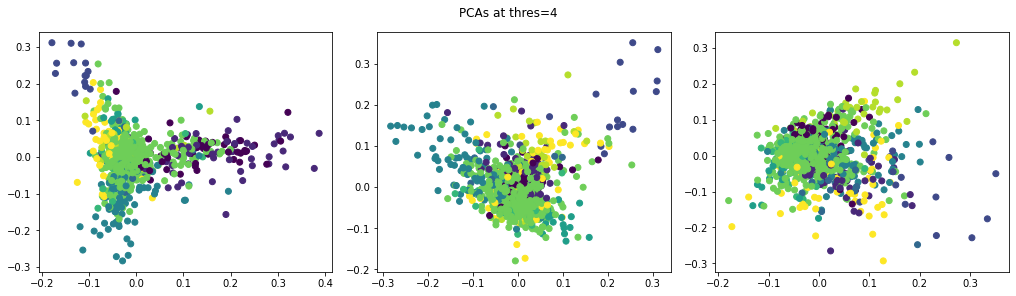

In [192]:
# Let's visualize on the 2 PCs
# color represents the cluster given the specified threshold

# Threshold:
thres = 4

from scipy.cluster.hierarchy import fcluster
y_predict = fcluster(linkage_matrix, t=thres, criterion='distance')

fig, ax = plt.subplots(1,3, figsize=(14,4), constrained_layout=True)
ax[0].scatter(X_pca[:,0], X_pca[:,1], c=y_predict)
ax[1].scatter(X_pca[:,1], X_pca[:,2], c=y_predict)
ax[2].scatter(X_pca[:,2], X_pca[:,3], c=y_predict)
plt.suptitle(f"PCAs at thres={thres}")


df_clustered = pd.DataFrame(all_data[2]['X'].toarray())
df_clustered['cluster'] = y_predict
# display(df_clustered.head())
print("Shape ", df_clustered.shape)
df_clustered['cluster'].value_counts()

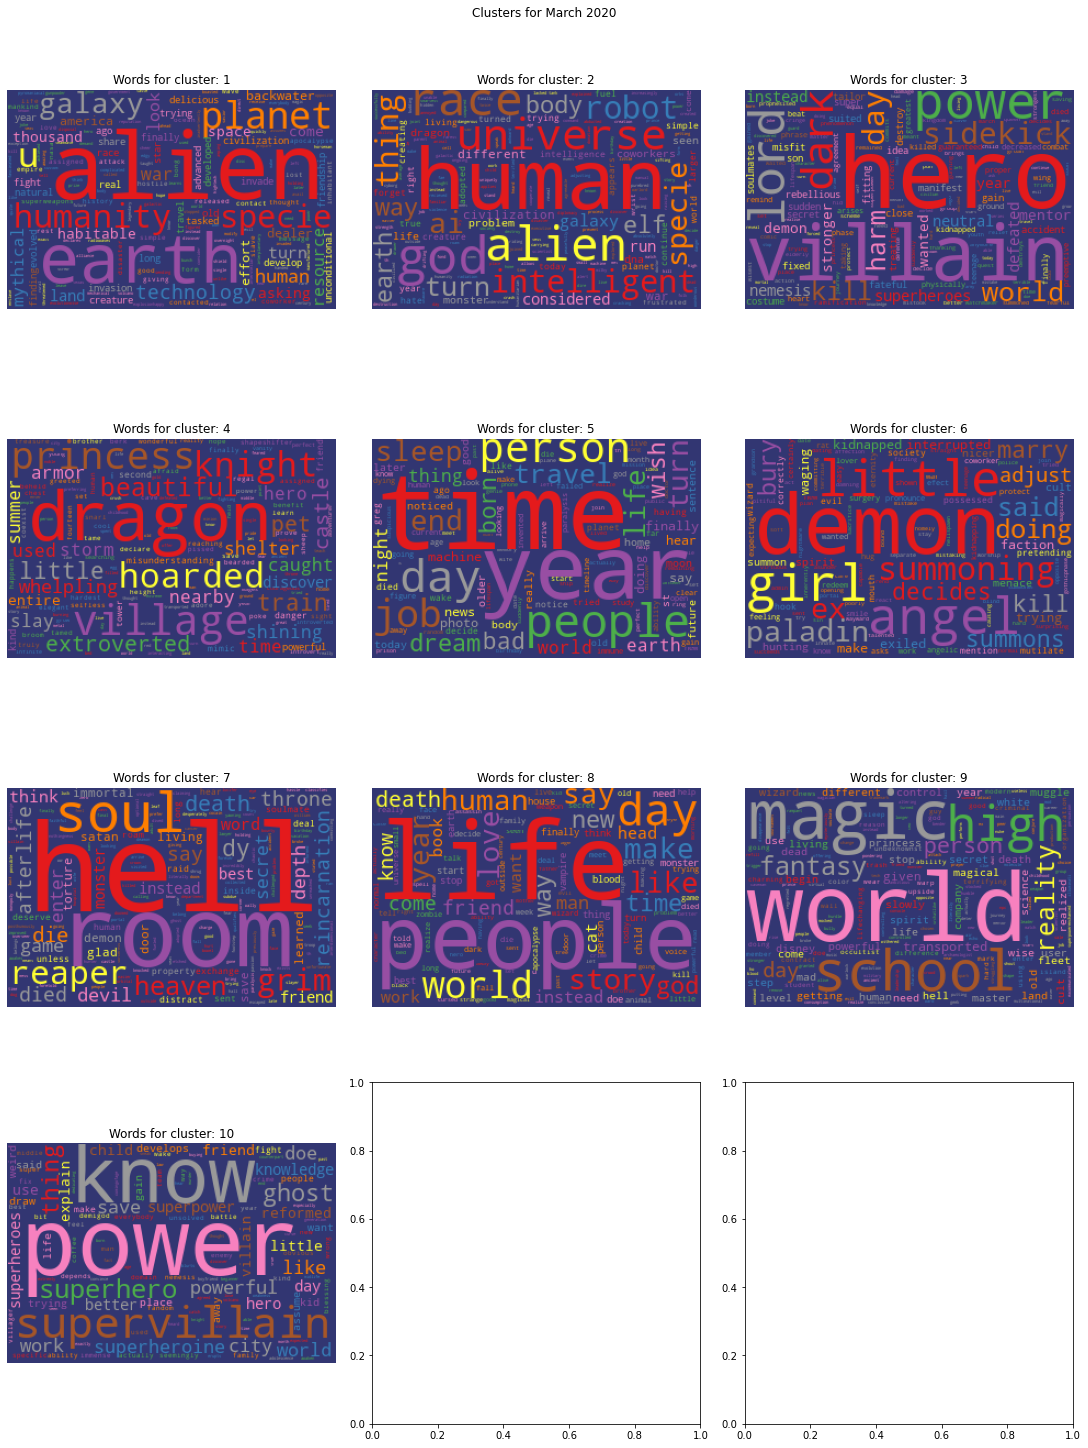

In [193]:
plot_cluster(all_data[2]['X'], y_predict, all_data[2]['feature_names'], 'March 2020')

Save clustering results to file

In [50]:
cluster3 = {
    'linkage_matrix': linkage_matrix,
    'y_predict':  y_predict
           }

# BE CAREFUL!
# Modify to True if you want to run the extraction again
overwrite = False

# Saving proper
if overwrite == True:

    with open(f"./data_postprocessed/cluster3.pkl","wb") as file:
        pickle.dump(cluster3, file)

### **April 2020**

Text(0.5, 0.98, 'PCAs of dataset')

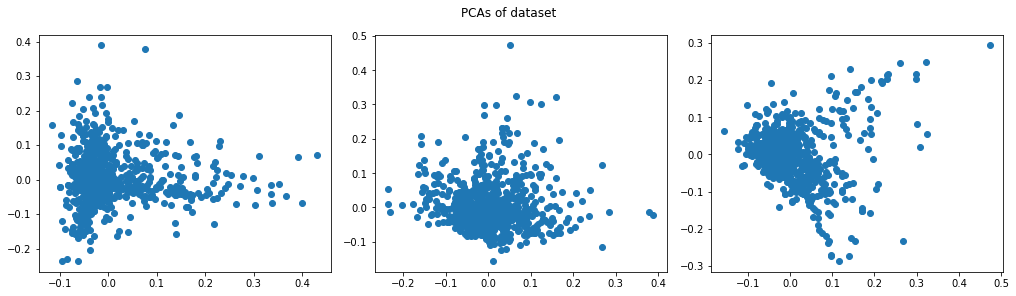

In [194]:
# Let's do PCA just to prep for visualization
from sklearn.decomposition import PCA

X_pca = PCA(n_components=4, random_state=1337).fit_transform(all_data[3]['X_new'])

fig, ax = plt.subplots(1,3, figsize=(14,4), constrained_layout=True)
ax[0].scatter(X_pca[:,0], X_pca[:,1])
ax[1].scatter(X_pca[:,1], X_pca[:,2])
ax[2].scatter(X_pca[:,2], X_pca[:,3])

plt.suptitle(f"PCAs of dataset")

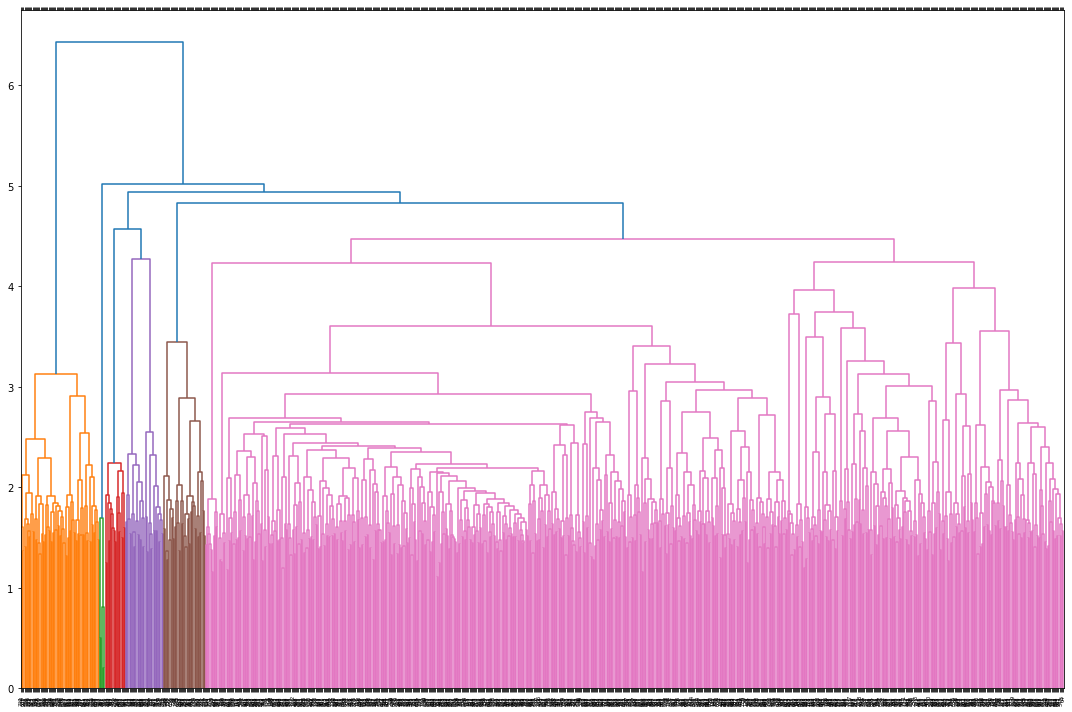

In [195]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import ward, dendrogram

dist = 1 - cosine_similarity(all_data[3]['X_new'])
linkage_matrix = ward(dist)

fig, ax = plt.subplots(figsize=(15, 10)) # set size
ax = dendrogram(linkage_matrix);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

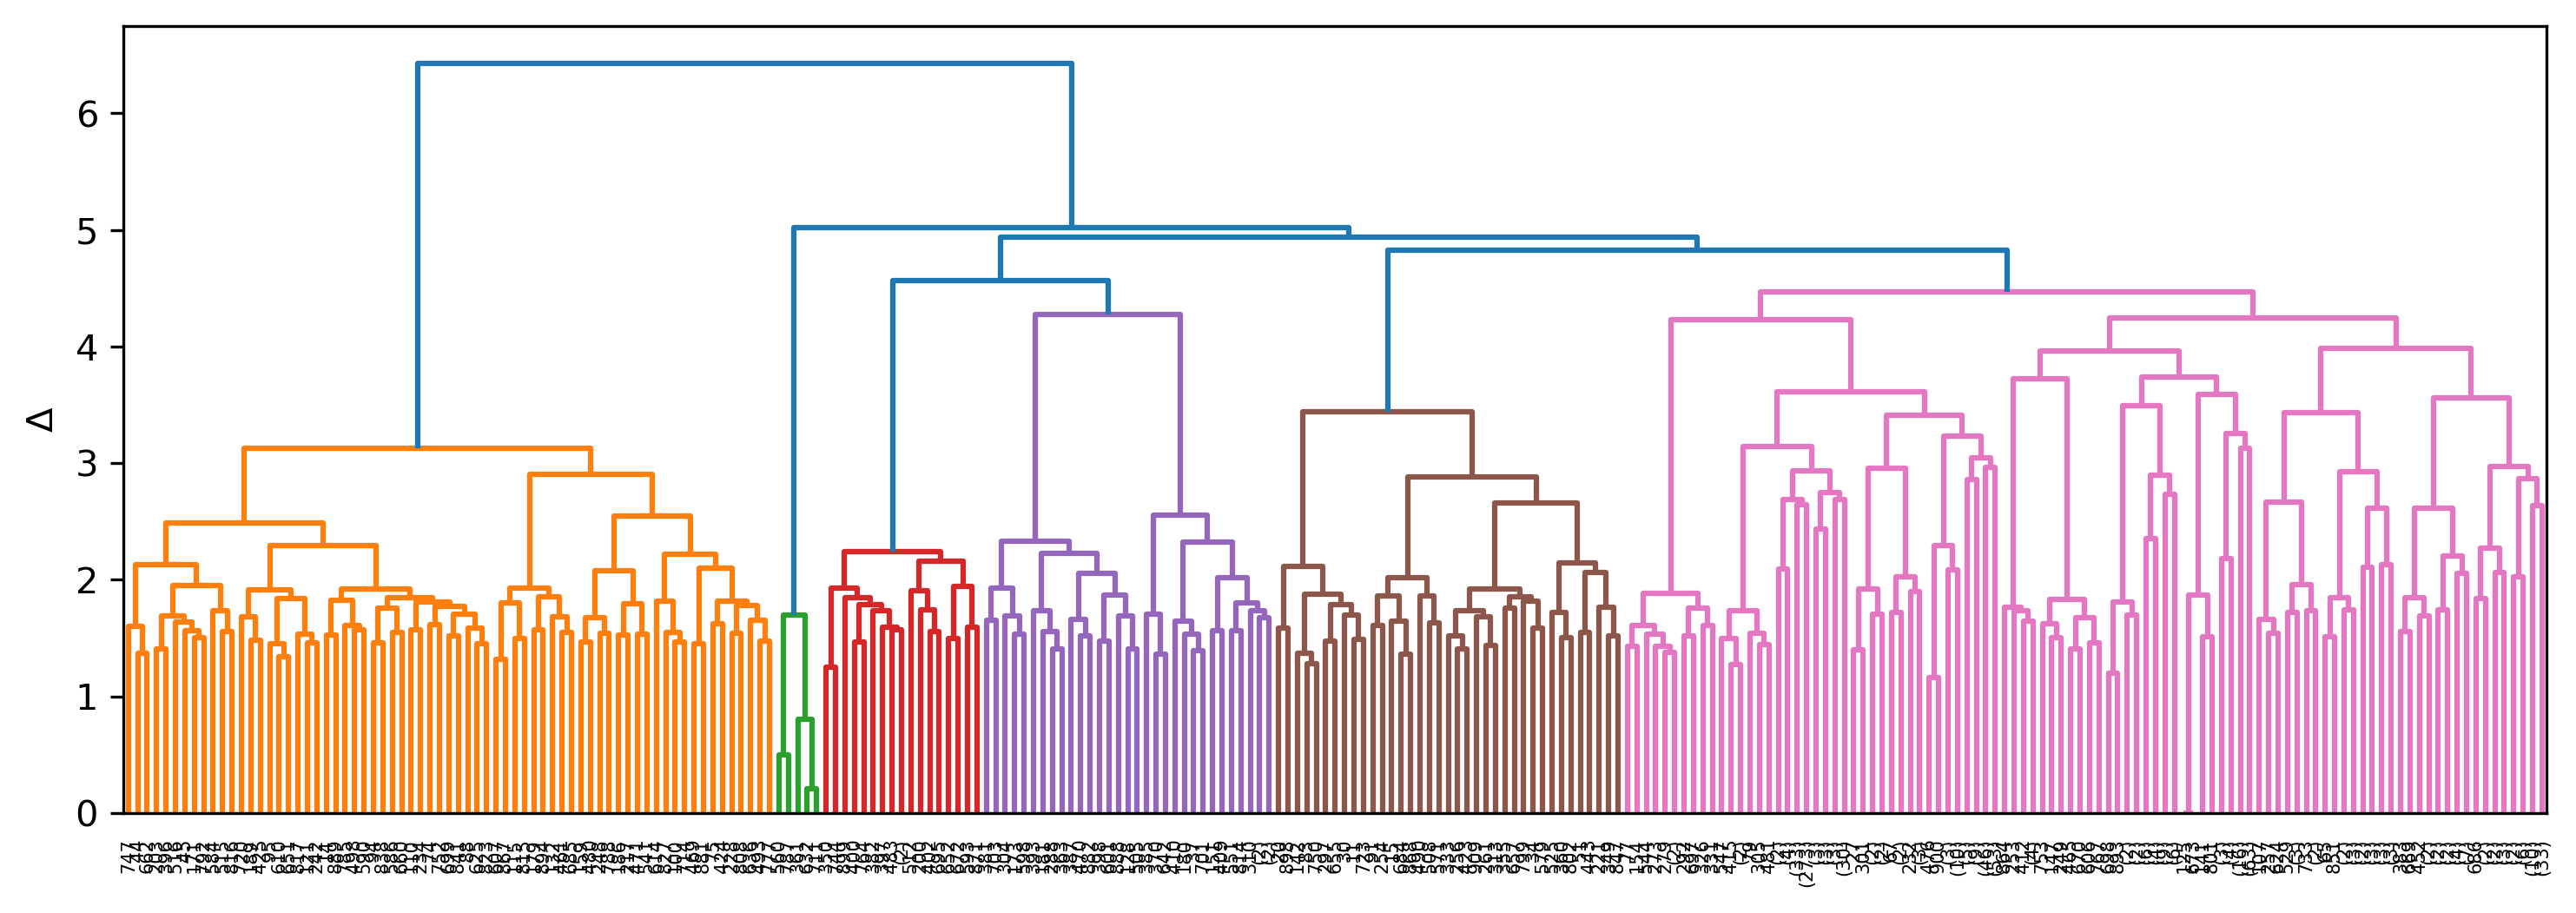

In [196]:
# What an ugly dendogram!
# Let's truncate on p=10

fig, ax = plt.subplots(figsize=(12,4), dpi=300)
dn = dendrogram(linkage_matrix, ax=ax, truncate_mode='level', p=10)
ax.set_ylabel(r'$\Delta$');

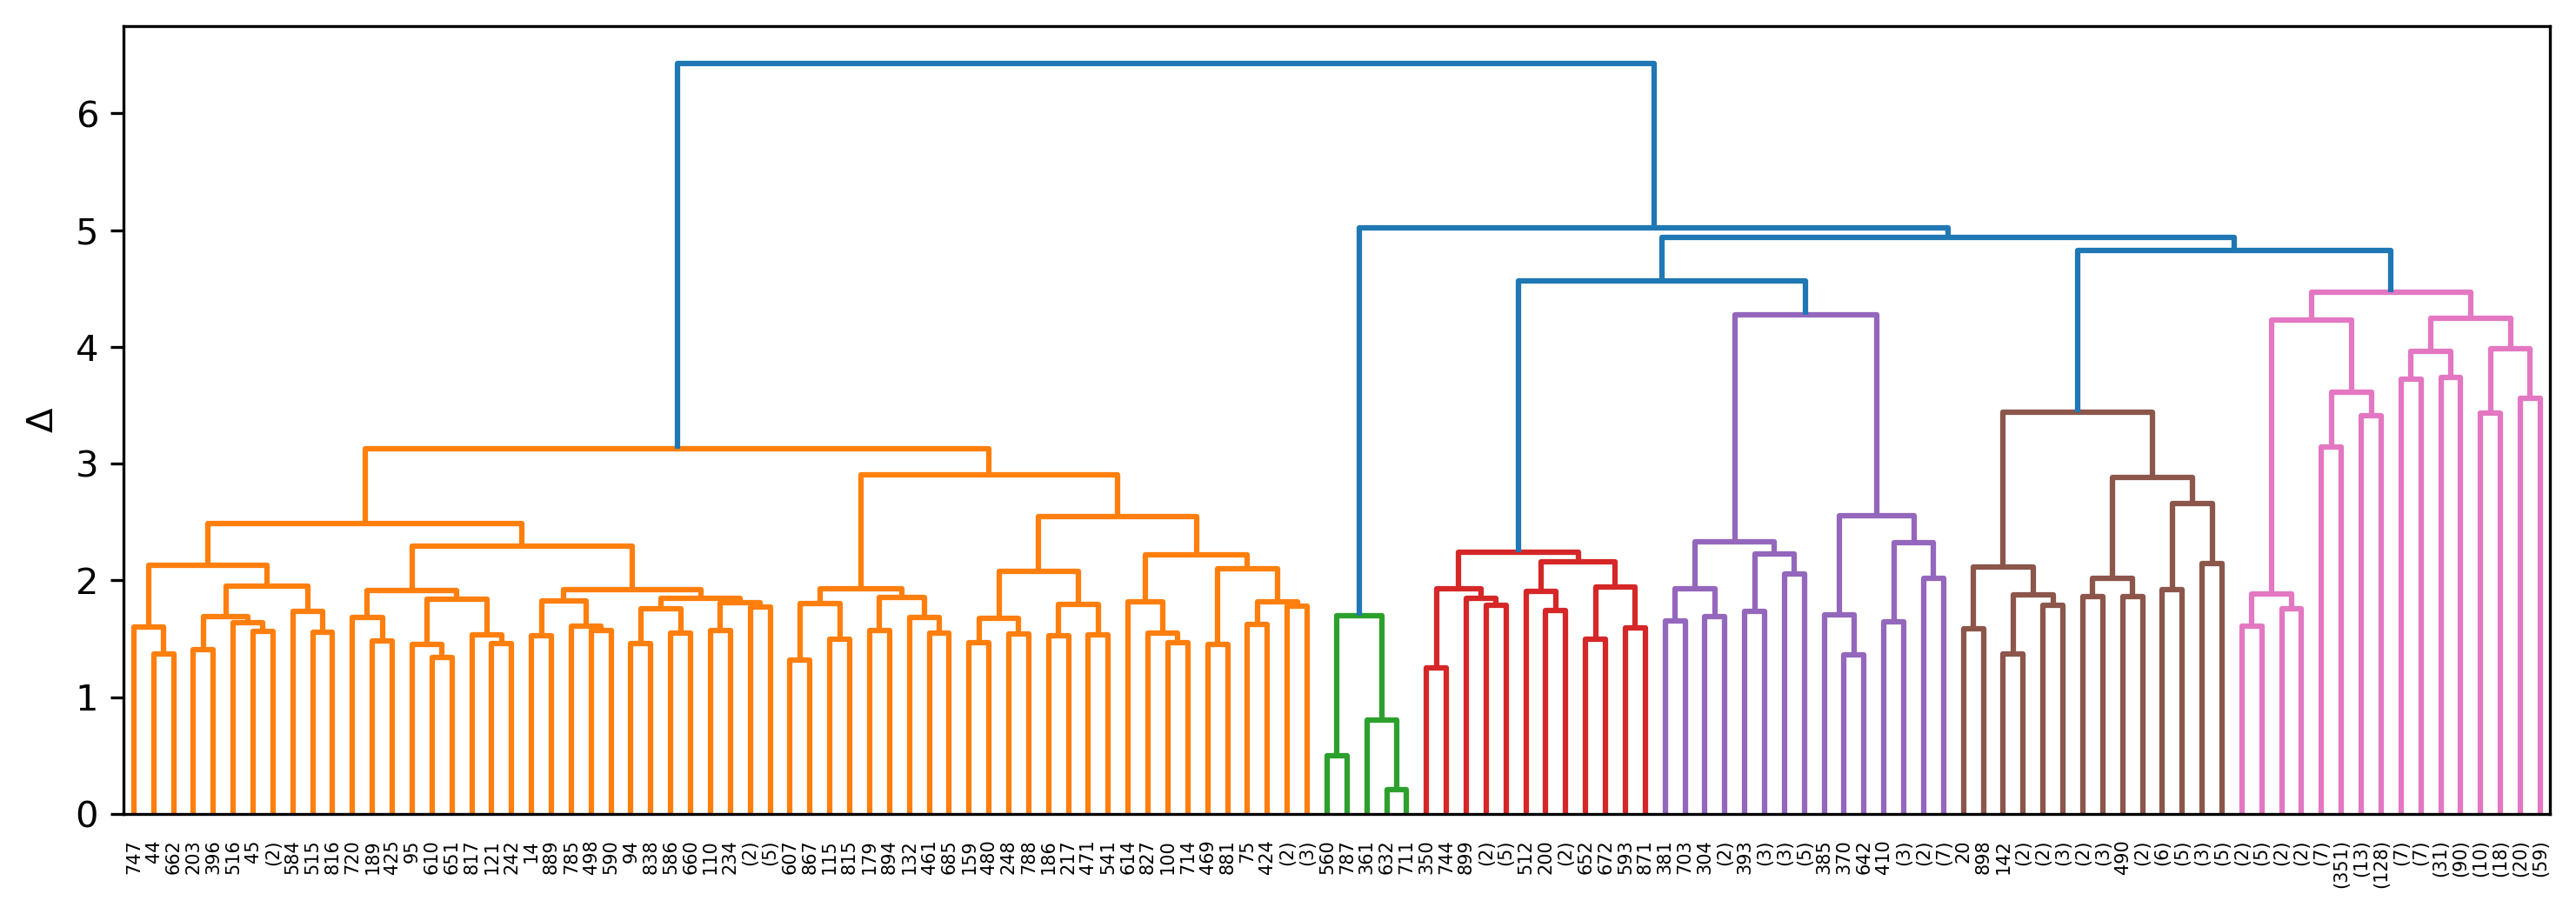

In [197]:
# What an ugly dendogram!
# Let's truncate on different p=7

fig, ax = plt.subplots(figsize=(12,4), dpi=300)
dn = dendrogram(linkage_matrix, ax=ax, truncate_mode='level', p=7)
ax.set_ylabel(r'$\Delta$');

Based on above dendograms, choose ```thres```.  We can try on that then do EDA if the SVs for those in the cluster make sense

Shape  (914, 4748)


8     499
10    121
12     79
1      69
6      37
11     28
3      18
4      17
5      16
9      14
7      11
2       5
Name: cluster, dtype: int64

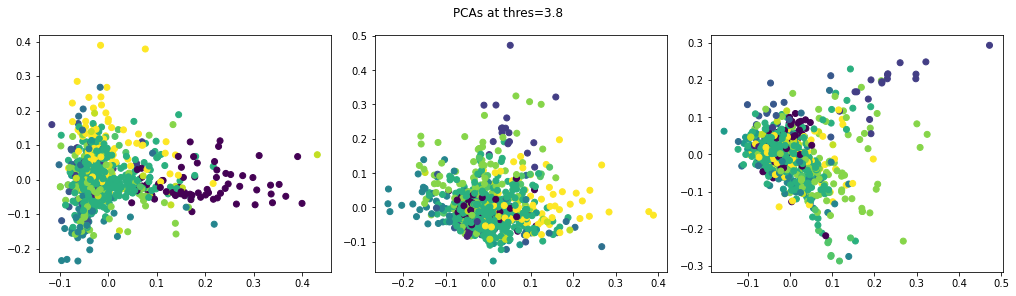

In [203]:
# Let's visualize on the 2 PCs
# color represents the cluster given the specified threshold

# Threshold:
thres = 3.8

from scipy.cluster.hierarchy import fcluster
y_predict = fcluster(linkage_matrix, t=thres, criterion='distance')

fig, ax = plt.subplots(1,3, figsize=(14,4), constrained_layout=True)
ax[0].scatter(X_pca[:,0], X_pca[:,1], c=y_predict)
ax[1].scatter(X_pca[:,1], X_pca[:,2], c=y_predict)
ax[2].scatter(X_pca[:,2], X_pca[:,3], c=y_predict)
plt.suptitle(f"PCAs at thres={thres}")


df_clustered = pd.DataFrame(all_data[3]['X'].toarray())
df_clustered['cluster'] = y_predict
# display(df_clustered.head())
print("Shape ", df_clustered.shape)
df_clustered['cluster'].value_counts()

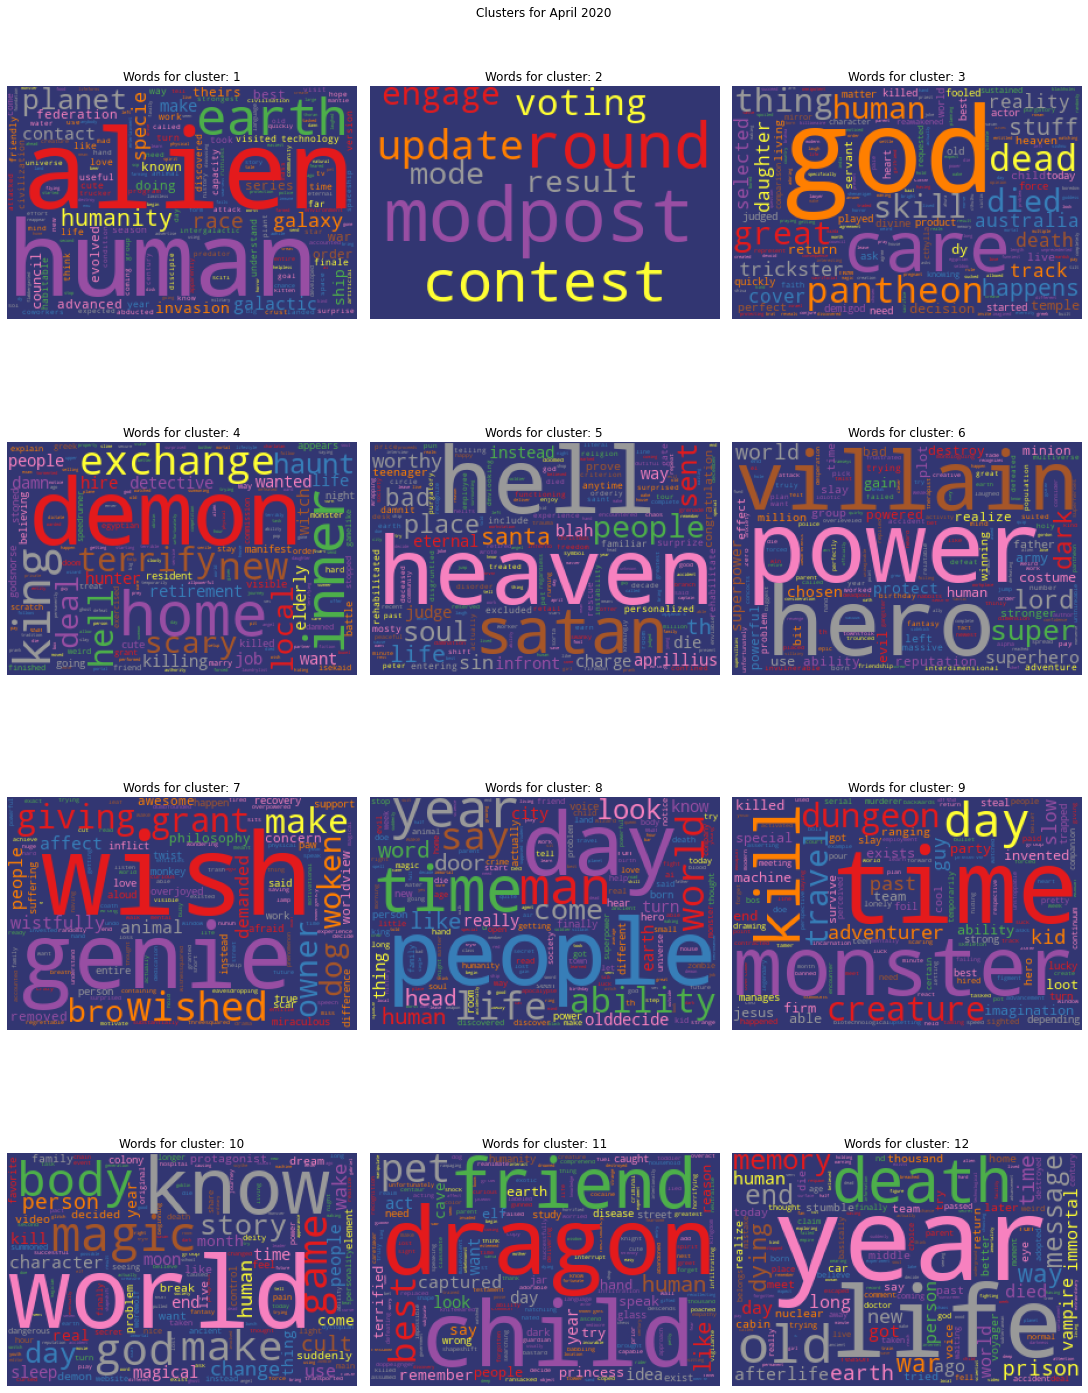

In [204]:
plot_cluster(all_data[3]['X'], y_predict, all_data[3]['feature_names'], 'April 2020')

Saving clusters to file

In [ ]:
cluster4 = {
    'linkage_matrix': linkage_matrix,
    'y_predict':  y_predict
           }

# BE CAREFUL!
# Modify to True if you want to run the extraction again
overwrite = False

# Saving proper
if overwrite == True:

    with open(f"./data_postprocessed/cluster4.pkl","wb") as file:
        pickle.dump(cluster4, file)